In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

In [3]:
bird = 'B1240'
d = 128

In [4]:
#ratings = [1,2,3]
#ratings_str = ''.join([str(x) for x in ratings])

In [5]:
#sort_path =  '/mnt/cube/srrudrar/sorted/B1596/block4/continuous/Rhythm_FPGA-100.0/'#
#
#clusters = []
#for rating in ratings:
#    x = tu.get_clusters_by_rating(sort_path, rating)
#    clusters.extend(x)
#
#n_cells = len(clusters)

In [6]:
#np.save('/mnt/cube/srrudrar/temporal_model/units_to_process_B1596.npy',clusters)

### Load dsets

In [7]:
stim_spec = np.load('/mnt/cube/srrudrar/pca_model/{}/32x32/stim_resp_32x32_{}/enc_test_{}_avg.npy'.format(bird,d,d)) ###change
stim_resp = np.load('/mnt/cube/srrudrar/pca_model/{}/32x32/stim_resp_32x32_{}/resp_test_{}_avg.npy'.format(bird,d,d))###change

In [8]:
np.shape(stim_spec), np.shape(stim_resp)

((5706, 128), (5706, 214, 32))

In [9]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=32, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [10]:
nsegbins = 32

In [11]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [12]:
np.shape(stim_mne), np.shape(resp_mne)

((5706, 128), (5706, 214))

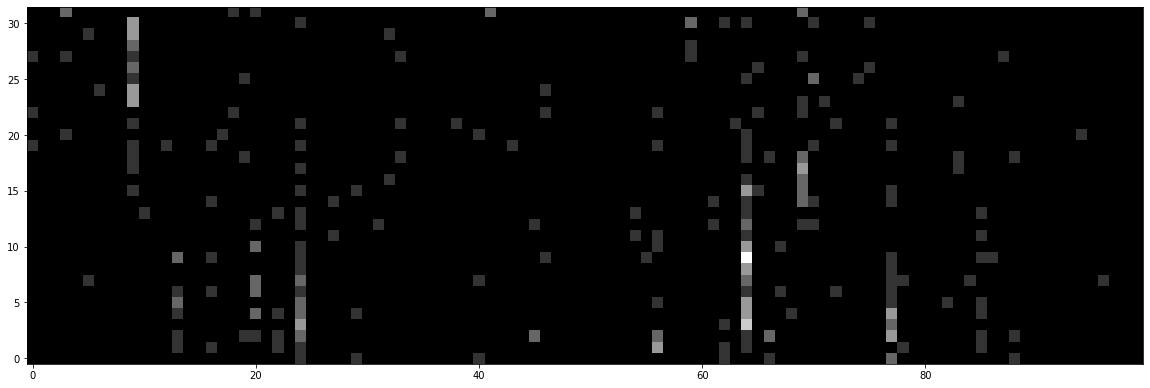

In [13]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [14]:
len_units = np.shape(resp_mne)[1]

In [15]:
units_to_process1 = list(np.load('/mnt/cube/srrudrar/temporal_model/units_to_process_{}.npy'.format(bird)))        ###change

In [16]:
import random
units_to_process = random.sample(units_to_process1, 50)

In [17]:
np.min(units_to_process)

18

In [18]:
exp_path = '/mnt/cube/srrudrar/pca_model/{}/32x32/stim_resp_32x32_{}/test_set_mne/'.format(bird,d)           ###change

In [19]:
# obtain all preprocessed datas

%matplotlib inline
sdim = d                                                                                                          ###change                                                                
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 
    1       0    0.187507
    2       0    0.171476
    3       0    0.175286
    4       1    0.167569
    5       0    0.162792
    6       0    0.164898
    7       1    0.162756
    8       0    0.164559
    9       1    0.162998
   10       2    0.164853
   11       3    0.163088
   12       4    0.158875
   13       0    0.160260
   14       1    0.158476
   15       0    0.161189
   16       1    0.159831
   17       2    0.158750
   18       3    0.159823
   19       4    0.160489
   20       5    0.159297
   21       6    0.159333
   22       7    0.160090
   23       8    0.160452
   24       9    0.165085
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.153408
    2       0    0.151043
    3       0    0.151312
    4       1    0.147932
    5       0    0.142937
    6       0    0.140135
    7       0    0.140560
    8       1    0.141507
    9       2    0.139158
   10       0    0.138343
   11       0    0.137577
   12       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.142388
    2       0    0.137567
    3       0    0.136565
    4       0    0.133231
    5       0    0.132361
    6       0    0.130867
    7       0    0.129794
    8       0    0.128054
    9       0    0.128247
   10       1    0.127714
   11       0    0.128682
   12       1    0.130216
   13       2    0.127433
   14       0    0.126133
   15       0    0.126558
   16       1    0.126160
   17       2    0.127124
   18       3    0.126702
   19       4    0.126058
   20       0    0.126276
   21       1    0.126805
   22       2    0.126410
   23       3    0.127943
   24       4    0.127088
   25       5    0.128589
   26       6    0.128103
   27       7    0.129485
   28       8    0.129174
   29       9    0.130906
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.157611
    2       0    0.144210
    3       0    0.141879
    4       0    0.139081
    5       0    0.139687
    6       1    0.142451
    7       2    0.140605
    8       3    0.134258
    9       0    0.135480
   10       1    0.133382
   11       0    0.134848
   12       1    0.136279
   13       2    0.135031
   14       3    0.133528
   15       4    0.133241
   16       0    0.136623
   17       1    0.136643
   18       2    0.134424
   19       3    0.133005
   20       0    0.132631
   21       0    0.133453
   22       1    0.133333
   23       2    0.132612
   24       0    0.133178
   25       1    0.132819
   26       2    0.133625
   27       3    0.133055
   28       4    0.134083
   29       5    0.135177
   30       6    0.135082
   31       7    0.136564
   32       8    0.135859
   33       9    0.135235
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.150899
    2       0    0.142227
    3       0    0.142025
    4       0    0.138316
    5       0    0.136179
    6       0    0.135715
    7       0    0.134237
    8       0    0.133711
    9       0    0.133437
   10       0    0.129650
   11       0    0.129242
   12       0    0.129424
   13       1    0.128875
   14       0    0.128973
   15       1    0.129355
   16       2    0.129112
   17       3    0.129576
   18       4    0.129467
   19       5    0.129120
   20       6    0.128782
   21       0    0.128474
   22       0    0.128529
   23       1    0.129242
   24       2    0.129538
   25       3    0.130671
   26       4    0.131220
   27       5    0.130401
   28       6    0.129448
   29       7    0.130008
   30       8    0.129976
   31       9    0.129557
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.166775
    2       0    0.160595
    3       0    0.157647
    4       0    0.151943
    5       0    0.152410
    6       1    0.152324
    7       2    0.149168
    8       0    0.147554
    9       0    0.147098
   10       0    0.147740
   11       1    0.147806
   12       2    0.144499
   13       0    0.146045
   14       1    0.146822
   15       2    0.146016
   16       3    0.145718
   17       4    0.144942
   18       5    0.145539
   19       6    0.145053
   20       7    0.145656
   21       8    0.146667
   22       9    0.146012
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.113236
    2       0    0.111594
    3       0    0.108523
    4       0    0.108375
    5       0    0.106632
    6       0    0.105874
    7       0    0.105722
    8       0    0.105387
    9       0    0.104759
   10       0    0.104941
   11       1    0.104989
   12       2    0.103165
   13       0    0.102866
   14       0    0.103138
   15       1    0.102990
   16       2    0.102176
   17       0    0.103133
   18       1    0.102913
   19       2    0.102167
   20       0    0.102281
   21       1    0.102451
   22       2    0.102270
   23       3    0.101919
   24       0    0.102183
   25       1    0.102066
   26       2    0.102332
   27       3    0.102217
   28       4    0.102552
   29       5    0.102471
   30       6    0.102719
   31       7    0.102712
   32       8    0.102994
   33       9    0.102535
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.116420
    2       0    0.112109
    3       0    0.111807
    4       0    0.108933
    5       0    0.107150
    6       0    0.106219
    7       0    0.106346
    8       1    0.105036
    9       0    0.104618
   10       0    0.104947
   11       1    0.105210
   12       2    0.103556
   13       0    0.103720
   14       1    0.103051
   15       0    0.103465
   16       1    0.104032
   17       2    0.103585
   18       3    0.103336
   19       4    0.103648
   20       5    0.103544
   21       6    0.103371
   22       7    0.103464
   23       8    0.103544
   24       9    0.103781
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.102919
    2       0    0.103310
    3       0    0.100594
    4       0    0.099524
    5       0    0.098665
    6       0    0.096837
    7       0    0.095579
    8       0    0.095086
    9       0    0.094726
   10       0    0.094861
   11       1    0.094836
   12       2    0.094621
   13       0    0.094340
   14       0    0.094277
   15       0    0.094076
   16       0    0.093666
   17       0    0.093684
   18       1    0.093316
   19       0    0.093418
   20       1    0.093270
   21       0    0.093433
   22       1    0.093610
   23       2    0.093466
   24       3    0.093101
   25       0    0.093255
   26       1    0.093343
   27       2    0.093972
   28       3    0.094003
   29       4    0.093988
   30       5    0.093661
   31       6    0.093516
   32       7    0.093321
   33       8    0.093599
   34       9    0.093477
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.121711
    2       0    0.118336
    3       0    0.116381
    4       0    0.113174
    5       0    0.113421
    6       1    0.109590
    7       0    0.109541
    8       0    0.109827
    9       1    0.110034
   10       2    0.109919
   11       3    0.109601
   12       4    0.109767
   13       5    0.109587
   14       6    0.109989
   15       7    0.109526
   16       0    0.109032
   17       0    0.109083
   18       1    0.109346
   19       2    0.109061
   20       3    0.109571
   21       4    0.109277
   22       5    0.109570
   23       6    0.109275
   24       7    0.109584
   25       8    0.109279
   26       9    0.109846
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.103564
    2       0    0.102423
    3       0    0.100525
    4       0    0.099065
    5       0    0.098353
    6       0    0.097338
    7       0    0.096904
    8       0    0.095480
    9       0    0.095315
   10       0    0.095000
   11       0    0.094642
   12       0    0.094395
   13       0    0.093861
   14       0    0.093842
   15       0    0.093745
   16       0    0.093608
   17       0    0.093386
   18       0    0.093374
   19       0    0.093071
   20       0    0.093178
   21       1    0.092916
   22       0    0.092593
   23       0    0.092584
   24       0    0.092283
   25       0    0.092278
   26       0    0.092295
   27       1    0.092217
   28       0    0.092160
   29       0    0.092218
   30       1    0.092203
   31       2    0.092448
   32       3    0.092508
   33       4    0.092836
   34       5    0.092793
   35       6    0.092756
   36       7    0.092935
   37       8    0.092846
   38       9    0.092946
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.097472
    2       0    0.095936
    3       0    0.094855
    4       0    0.094747
    5       0    0.093527
    6       0    0.092289
    7       0    0.092215
    8       0    0.091615
    9       0    0.091363
   10       0    0.091076
   11       0    0.090599
   12       0    0.089993
   13       0    0.089589
   14       0    0.089149
   15       0    0.088335
   16       0    0.088440
   17       1    0.088629
   18       2    0.088143
   19       0    0.087674
   20       0    0.087752
   21       1    0.087432
   22       0    0.087484
   23       1    0.087727
   24       2    0.087448
   25       3    0.087591
   26       4    0.087477
   27       5    0.087589
   28       6    0.087367
   29       0    0.087434
   30       1    0.087160
   31       0    0.087197
   32       1    0.086829
   33       0    0.086992
   34       1    0.087217
   35       2    0.086955
   36       3    0.086958
   37       4    0.087404
   38       5    0.087505
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.099157
    2       0    0.096911
    3       0    0.097065
    4       1    0.094254
    5       0    0.094681
    6       1    0.094668
    7       2    0.094146
    8       0    0.092529
    9       0    0.091677
   10       0    0.091841
   11       1    0.091379
   12       0    0.090944
   13       0    0.090746
   14       0    0.090664
   15       0    0.090409
   16       0    0.089980
   17       0    0.089631
   18       0    0.089858
   19       1    0.090448
   20       2    0.090272
   21       3    0.089575
   22       0    0.089340
   23       0    0.089492
   24       1    0.089523
   25       2    0.089391
   26       3    0.089576
   27       4    0.089501
   28       5    0.089712
   29       6    0.089541
   30       7    0.089350
   31       8    0.089428
   32       9    0.089274
   33       0    0.089422
   34       1    0.089378
   35       2    0.089208
   36       0    0.089218
   37       1    0.089292
   38       2    0.089230
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.106741
    2       0    0.103453
    3       0    0.103364
    4       0    0.101770
    5       0    0.100064
    6       0    0.098867
    7       0    0.097929
    8       0    0.097712
    9       0    0.097859
   10       1    0.097684
   11       0    0.096835
   12       0    0.097144
   13       1    0.097278
   14       2    0.096358
   15       0    0.096160
   16       0    0.096301
   17       1    0.095889
   18       0    0.095624
   19       0    0.095407
   20       0    0.095232
   21       0    0.095829
   22       1    0.095484
   23       2    0.095173
   24       0    0.094847
   25       0    0.095358
   26       1    0.095104
   27       2    0.094836
   28       0    0.095096
   29       1    0.095193
   30       2    0.094992
   31       3    0.094894
   32       4    0.095069
   33       5    0.095117
   34       6    0.094867
   35       7    0.094860
   36       8    0.094973
   37       9    0.094959
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.206267
    2       0    0.198699
    3       0    0.195912
    4       0    0.191047
    5       0    0.191252
    6       1    0.191459
    7       2    0.190379
    8       0    0.187822
    9       0    0.187742
   10       0    0.185895
   11       0    0.185486
   12       0    0.185816
   13       1    0.185854
   14       2    0.185498
   15       3    0.184518
   16       0    0.183860
   17       0    0.184096
   18       1    0.183862
   19       2    0.183600
   20       0    0.183809
   21       1    0.183868
   22       2    0.183563
   23       0    0.183397
   24       0    0.183539
   25       1    0.183489
   26       2    0.185132
   27       3    0.183559
   28       4    0.183054
   29       0    0.183528
   30       1    0.183586
   31       2    0.184523
   32       3    0.184417
   33       4    0.183996
   34       5    0.184147
   35       6    0.183871
   36       7    0.184015
   37       8    0.183672
   38       9    0.183712
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.205072
    2       0    0.204399
    3       0    0.198547
    4       0    0.193804
    5       0    0.192259
    6       0    0.191127
    7       0    0.190640
    8       0    0.189230
    9       0    0.189466
   10       1    0.190853
   11       2    0.189187
   12       0    0.187923
   13       0    0.188180
   14       1    0.189167
   15       2    0.187467
   16       0    0.188385
   17       1    0.187818
   18       2    0.186550
   19       0    0.186949
   20       1    0.187627
   21       2    0.186224
   22       0    0.186864
   23       1    0.185795
   24       0    0.186555
   25       1    0.187066
   26       2    0.186423
   27       3    0.187092
   28       4    0.186484
   29       5    0.187149
   30       6    0.186909
   31       7    0.187157
   32       8    0.186373
   33       9    0.186583
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.187732
    2       0    0.184229
    3       0    0.182199
    4       0    0.176727
    5       0    0.176133
    6       0    0.174441
    7       0    0.173580
    8       0    0.172440
    9       0    0.172347
   10       0    0.172586
   11       1    0.172905
   12       2    0.171414
   13       0    0.170331
   14       0    0.168899
   15       0    0.168720
   16       0    0.168757
   17       1    0.168712
   18       0    0.168414
   19       0    0.168414
   20       0    0.168468
   21       1    0.168459
   22       2    0.168295
   23       0    0.168147
   24       0    0.168249
   25       1    0.168292
   26       2    0.168133
   27       0    0.168216
   28       1    0.168086
   29       0    0.168190
   30       1    0.168378
   31       2    0.168145
   32       3    0.168019
   33       0    0.168148
   34       1    0.167984
   35       0    0.167906
   36       0    0.167970
   37       1    0.167909
   38       2    0.167960
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.202016
    2       0    0.196202
    3       0    0.193380
    4       0    0.189333
    5       0    0.189413
    6       1    0.187717
    7       0    0.187539
    8       0    0.185994
    9       0    0.185075
   10       0    0.183655
   11       0    0.183422
   12       0    0.183079
   13       0    0.183171
   14       1    0.183475
   15       2    0.183299
   16       3    0.183547
   17       4    0.182878
   18       0    0.183004
   19       1    0.183216
   20       2    0.182576
   21       0    0.182695
   22       1    0.182935
   23       2    0.183061
   24       3    0.182727
   25       4    0.182938
   26       5    0.183130
   27       6    0.182819
   28       7    0.182992
   29       8    0.182818
   30       9    0.182753
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.072716
    2       0    0.070390
    3       0    0.069299
    4       0    0.069533
    5       1    0.068791
    6       0    0.069217
    7       1    0.068512
    8       0    0.069584
    9       1    0.069087
   10       2    0.068208
   11       0    0.068694
   12       1    0.069405
   13       2    0.069156
   14       3    0.068399
   15       4    0.068246
   16       5    0.068603
   17       6    0.068448
   18       7    0.068143
   19       0    0.068891
   20       1    0.068858
   21       2    0.069304
   22       3    0.068825
   23       4    0.068915
   24       5    0.069271
   25       6    0.068987
   26       7    0.069385
   27       8    0.069016
   28       9    0.069218
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.066868
    2       0    0.064647
    3       0    0.063286
    4       0    0.062883
    5       0    0.061523
    6       0    0.060468
    7       0    0.062194
    8       1    0.061906
    9       2    0.060295
   10       0    0.059486
   11       0    0.059824
   12       1    0.059660
   13       2    0.059390
   14       0    0.059534
   15       1    0.059771
   16       2    0.059348
   17       0    0.059850
   18       1    0.059451
   19       2    0.059223
   20       0    0.059557
   21       1    0.059576
   22       2    0.059793
   23       3    0.060009
   24       4    0.059757
   25       5    0.059799
   26       6    0.060744
   27       7    0.060602
   28       8    0.061961
   29       9    0.062848
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.069359
    2       0    0.066339
    3       0    0.064588
    4       0    0.065982
    5       1    0.064441
    6       0    0.063080
    7       0    0.062279
    8       0    0.061752
    9       0    0.061752
   10       1    0.062046
   11       2    0.061198
   12       0    0.061659
   13       1    0.060899
   14       0    0.061620
   15       1    0.062394
   16       2    0.061265
   17       3    0.061434
   18       4    0.061730
   19       5    0.061254
   20       6    0.061594
   21       7    0.061440
   22       8    0.061918
   23       9    0.061774
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.073288
    2       0    0.070590
    3       0    0.068581
    4       0    0.068571
    5       0    0.067653
    6       0    0.066984
    7       0    0.066932
    8       0    0.067285
    9       1    0.066067
   10       0    0.066523
   11       1    0.066022
   12       0    0.066517
   13       1    0.065792
   14       0    0.065890
   15       1    0.066312
   16       2    0.066151
   17       3    0.066554
   18       4    0.067097
   19       5    0.066737
   20       6    0.066809
   21       7    0.066610
   22       8    0.067115
   23       9    0.067585
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.093948
    2       0    0.091222
    3       0    0.090960
    4       0    0.091011
    5       1    0.091173
    6       2    0.090666
    7       0    0.088577
    8       0    0.088169
    9       0    0.087542
   10       0    0.087089
   11       0    0.086853
   12       0    0.085547
   13       0    0.085494
   14       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.099674
    2       0    0.097375
    3       0    0.098209
    4       1    0.097916
    5       2    0.096359
    6       0    0.094621
    7       0    0.094020
    8       0    0.093324
    9       0    0.093969
   10       1    0.092868
   11       0    0.092982
   12       1    0.093016
   13       2    0.092106
   14       0    0.092321
   15       1    0.092019
   16       0    0.092146
   17       1    0.092337
   18       2    0.092019
   19       0    0.092280
   20       1    0.091998
   21       0    0.092612
   22       1    0.092394
   23       2    0.092770
   24       3    0.092566
   25       4    0.092677
   26       5    0.092496
   27       6    0.092789
   28       7    0.092669
   29       8    0.092690
   30       9    0.093086
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.101250
    2       0    0.096962
    3       0    0.097877
    4       1    0.097020
    5       2    0.094882
    6       0    0.093372
    7       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.102304
    2       0    0.096964
    3       0    0.099205
    4       1    0.099817
    5       2    0.096608
    6       0    0.095017
    7       0    0.094342
    8       0    0.092657
    9       0    0.093062
   10       1    0.092260
   11       0    0.091850
   12       0    0.091251
   13       0    0.091714
   14       1    0.091324
   15       2    0.092263
   16       3    0.092567
   17       4    0.093577
   18       5    0.093184
   19       6    0.092294
   20       7    0.092269
   21       8    0.091772
   22       9    0.091542
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.122214
    2       0    0.120210
    3       0    0.119445
    4       0    0.115536
    5       0    0.115099
    6       0    0.112883
    7       0    0.112789
    8       0    0.111484
    9       0    0.111710
   10       1    0.110429
   11       0    0.109762
   12       0    0.110104
   13       1    0.110067
   14       2    0.109066
   15       0    0.109513
   16       1    0.109307
   17       2    0.109317
   18       3    0.109564
   19       4    0.110250
   20       5    0.109566
   21       6    0.109976
   22       7    0.110179
   23       8    0.109746
   24       9    0.109880
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.129238
    2       0    0.129701
    3       0    0.124688
    4       0    0.121781
    5       0    0.118029
    6       0    0.117051
    7       0    0.116486
    8       0    0.116703
    9       1    0.115411
   10       0    0.115858
   11       1    0.116250
   12       2    0.115059
   13       0    0.115557
   14       1    0.114281
   15       0    0.114870
   16       1    0.116139
   17       2    0.115372
   18       3    0.114924
   19       4    0.114307
   20       5    0.113889
   21       0    0.114254
   22       1    0.113704
   23       0    0.115334
   24       1    0.114791
   25       2    0.113759
   26       3    0.114588
   27       4    0.113992
   28       5    0.114414
   29       6    0.114631
   30       7    0.114996
   31       8    0.115146
   32       9    0.114721
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.126179
    2       0    0.118028
    3       0    0.116613
    4       0    0.116087
    5       0    0.115735
    6       0    0.113581
    7       0    0.111904
    8       0    0.111030
    9       0    0.110358
   10       0    0.110758
   11       1    0.110698
   12       2    0.110924
   13       3    0.110508
   14       4    0.109440
   15       0    0.109634
   16       1    0.109274
   17       0    0.109581
   18       1    0.109474
   19       2    0.108141
   20       0    0.108578
   21       1    0.109017
   22       2    0.108624
   23       3    0.108507
   24       4    0.108407
   25       5    0.109223
   26       6    0.109202
   27       7    0.108627
   28       8    0.108854
   29       9    0.108910
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.120422
    2       0    0.119053
    3       0    0.120737
    4       1    0.117773
    5       0    0.116368
    6       0    0.115330
    7       0    0.113367
    8       0    0.112396
    9       0    0.110437
   10       0    0.110647
   11       1    0.109482
   12       0    0.109851
   13       1    0.109539
   14       2    0.109135
   15       0    0.108838
   16       0    0.109342
   17       1    0.108871
   18       2    0.107867
   19       0    0.107959
   20       1    0.108143
   21       2    0.108010
   22       3    0.107808
   23       0    0.107647
   24       0    0.108369
   25       1    0.108153
   26       2    0.108244
   27       3    0.107895
   28       4    0.107681
   29       5    0.107976
   30       6    0.108485
   31       7    0.108440
   32       8    0.108884
   33       9    0.109566
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.141771
    2       0    0.133352
    3       0    0.131937
    4       0    0.130425
    5       0    0.131340
    6       1    0.128385
    7       0    0.125881
    8       0    0.126448
    9       1    0.127518
   10       2    0.124419
   11       0    0.123904
   12       0    0.124503
   13       1    0.125494
   14       2    0.123192
   15       0    0.124184
   16       1    0.124991
   17       2    0.123496
   18       3    0.123392
   19       4    0.124275
   20       5    0.124758
   21       6    0.124096
   22       7    0.124115
   23       8    0.123727
   24       9    0.124487
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.132238
    2       0    0.128067
    3       0    0.127771
    4       0    0.123584
    5       0    0.123000
    6       0    0.123069
    7       1    0.122296
    8       0    0.122765
    9       1    0.121093
   10       0    0.118540
   11       0    0.118392
   12       0    0.118699
   13       1    0.118591
   14       2    0.119668
   15       3    0.119686
   16       4    0.118229
   17       0    0.117777
   18       0    0.117199
   19       0    0.117049
   20       0    0.117153
   21       1    0.116744
   22       0    0.116487
   23       0    0.116708
   24       1    0.116163
   25       0    0.116321
   26       1    0.115772
   27       0    0.116429
   28       1    0.117205
   29       2    0.117231
   30       3    0.117773
   31       4    0.117757
   32       5    0.118020
   33       6    0.118095
   34       7    0.118657
   35       8    0.118557
   36       9    0.118274
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.147667
    2       0    0.139557
    3       0    0.138556
    4       0    0.135405
    5       0    0.135276
    6       0    0.132420
    7       0    0.131161
    8       0    0.129992
    9       0    0.130300
   10       1    0.130325
   11       2    0.129634
   12       0    0.129156
   13       0    0.128809
   14       0    0.128750
   15       0    0.127561
   16       0    0.126649
   17       0    0.126948
   18       1    0.127326
   19       2    0.127183
   20       3    0.126924
   21       4    0.127709
   22       5    0.128076
   23       6    0.127607
   24       7    0.127313
   25       8    0.127402
   26       9    0.127144
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.121704
    2       0    0.120995
    3       0    0.116738
    4       0    0.114943
    5       0    0.112629
    6       0    0.111620
    7       0    0.110291
    8       0    0.109581
    9       0    0.109627
   10       1    0.108802
   11       0    0.108506
   12       0    0.108214
   13       0    0.107918
   14       0    0.108102
   15       1    0.107687
   16       0    0.108009
   17       1    0.107585
   18       0    0.107681
   19       1    0.107365
   20       0    0.107621
   21       1    0.107379
   22       2    0.107012
   23       0    0.107235
   24       1    0.106926
   25       0    0.106822
   26       0    0.107094
   27       1    0.107515
   28       2    0.107247
   29       3    0.107410
   30       4    0.107341
   31       5    0.107521
   32       6    0.107336
   33       7    0.107610
   34       8    0.107412
   35       9    0.107966
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.168151
    2       0    0.164799
    3       0    0.164739
    4       0    0.161434
    5       0    0.157997
    6       0    0.157442
    7       0    0.156884
    8       0    0.157099
    9       1    0.156259
   10       0    0.154820
   11       0    0.154586
   12       0    0.154622
   13       1    0.154087
   14       0    0.154553
   15       1    0.153926
   16       0    0.152070
   17       0    0.151131
   18       0    0.151409
   19       1    0.151402
   20       2    0.151054
   21       0    0.151036
   22       0    0.150944
   23       0    0.151536
   24       1    0.151931
   25       2    0.150840
   26       0    0.150783
   27       0    0.150889
   28       1    0.150378
   29       0    0.150525
   30       1    0.150317
   31       0    0.150600
   32       1    0.150787
   33       2    0.150477
   34       3    0.150509
   35       4    0.150705
   36       5    0.150519
   37       6    0.150528
   38       7    0.151037
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.166598
    2       0    0.159474
    3       0    0.159729
    4       1    0.157055
    5       0    0.155826
    6       0    0.156355
    7       1    0.156130
    8       2    0.156117
    9       3    0.155904
   10       4    0.154252
   11       0    0.153319
   12       0    0.152402
   13       0    0.152524
   14       1    0.151048
   15       0    0.151463
   16       1    0.152349
   17       2    0.151882
   18       3    0.151542
   19       4    0.151757
   20       5    0.151544
   21       6    0.153057
   22       7    0.152942
   23       8    0.153426
   24       9    0.153267
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.146528
    2       0    0.144644
    3       0    0.144897
    4       1    0.139535
    5       0    0.139691
    6       1    0.139179
    7       0    0.139103
    8       0    0.138396
    9       0    0.138033
   10       0    0.137638
   11       0    0.138013
   12       1    0.137306
   13       0    0.137394
   14       1    0.137182
   15       0    0.136829
   16       0    0.136744
   17       0    0.136762
   18       1    0.136879
   19       2    0.136842
   20       3    0.136746
   21       4    0.136580
   22       0    0.136591
   23       1    0.136692
   24       2    0.136092
   25       0    0.136093
   26       1    0.135955
   27       0    0.135908
   28       0    0.136084
   29       1    0.136055
   30       2    0.135760
   31       0    0.135810
   32       1    0.136255
   33       2    0.136260
   34       3    0.135918
   35       4    0.135954
   36       5    0.135940
   37       6    0.135789
   38       7    0.135986
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.164192
    2       0    0.157865
    3       0    0.160084
    4       1    0.160374
    5       2    0.155946
    6       0    0.153604
    7       0    0.154328
    8       1    0.153192
    9       0    0.151808
   10       0    0.152035
   11       1    0.151884
   12       2    0.150954
   13       0    0.150821
   14       0    0.151116
   15       1    0.151323
   16       2    0.152168
   17       3    0.151004
   18       4    0.151547
   19       5    0.152673
   20       6    0.154050
   21       7    0.153402
   22       8    0.152622
   23       9    0.153191
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.319728
    2       0    0.313166
    3       0    0.311449
    4       0    0.302382
    5       0    0.301334
    6       0    0.299688
    7       0    0.298112
    8       0    0.296324
    9       0    0.296302
   10       0    0.297059
   11       1    0.296959
   12       2    0.295806
   13       0    0.296532
   14       1    0.295946
   15       2    0.295120
   16       0    0.294813
   17       0    0.291359
   18       0    0.290768
   19       0    0.288410
   20       0    0.288214
   21       0    0.287798
   22       0    0.287708
   23       0    0.288324
   24       1    0.288453
   25       2    0.289099
   26       3    0.289211
   27       4    0.289582
   28       5    0.289538
   29       6    0.289827
   30       7    0.289551
   31       8    0.288977
   32       9    0.287408
   33       0    0.287016
   34       0    0.286977
   35       0    0.286888
   36       0    0.287088
   37       1    0.287751
   38       2    0.288823
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.313819
    2       0    0.305926
    3       0    0.304802
    4       0    0.299320
    5       0    0.298375
    6       0    0.294104
    7       0    0.292833
    8       0    0.293429
    9       1    0.293976
   10       2    0.288824
   11       0    0.287739
   12       0    0.286117
   13       0    0.285523
   14       0    0.283458
   15       0    0.283440
   16       0    0.282884
   17       0    0.283071
   18       1    0.283206
   19       2    0.283567
   20       3    0.284196
   21       4    0.284225
   22       5    0.284044
   23       6    0.283714
   24       7    0.283271
   25       8    0.282818
   26       0    0.282459
   27       0    0.282069
   28       0    0.282154
   29       1    0.281901
   30       0    0.281793
   31       0    0.281481
   32       0    0.281617
   33       1    0.281429
   34       0    0.282420
   35       1    0.282258
   36       2    0.283110
   37       3    0.283310
   38       4    0.282348
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.292710
    2       0    0.285249
    3       0    0.285022
    4       0    0.281712
    5       0    0.279388
    6       0    0.276813
    7       0    0.275910
    8       0    0.273676
    9       0    0.274075
   10       1    0.273751
   11       2    0.268997
   12       0    0.266213
   13       0    0.266928
   14       1    0.267629
   15       2    0.266119
   16       0    0.264005
   17       0    0.264724
   18       1    0.263211
   19       0    0.262823
   20       0    0.264095
   21       1    0.263267
   22       2    0.262680
   23       0    0.262284
   24       0    0.261184
   25       0    0.261452
   26       1    0.260102
   27       0    0.260695
   28       1    0.261111
   29       2    0.261683
   30       3    0.260887
   31       4    0.261188
   32       5    0.260883
   33       6    0.261370
   34       7    0.261493
   35       8    0.262628
   36       9    0.262680
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.305981
    2       0    0.303403
    3       0    0.302691
    4       0    0.301892
    5       0    0.297428
    6       0    0.296833
    7       0    0.289190
    8       0    0.288541
    9       0    0.290010
   10       1    0.290828
   11       2    0.289455
   12       3    0.288132
   13       0    0.285637
   14       0    0.282352
   15       0    0.282096
   16       0    0.282687
   17       1    0.282550
   18       2    0.281764
   19       0    0.281307
   20       0    0.279331
   21       0    0.279466
   22       1    0.280123
   23       2    0.279929
   24       3    0.279636
   25       4    0.280913
   26       5    0.280977
   27       6    0.279225
   28       0    0.279332
   29       1    0.279720
   30       2    0.279417
   31       3    0.279190
   32       0    0.279354
   33       1    0.279794
   34       2    0.279144
   35       0    0.278907
   36       0    0.278481
   37       0    0.278747
   38       1    0.278906
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.116458
    2       0    0.109159
    3       0    0.107953
    4       0    0.107411
    5       0    0.105726
    6       0    0.105823
    7       1    0.106114
    8       2    0.104771
    9       0    0.103976
   10       0    0.103053
   11       0    0.103101
   12       1    0.102656
   13       0    0.102631
   14       0    0.102682
   15       1    0.102201
   16       0    0.101821
   17       0    0.101811
   18       0    0.101657
   19       0    0.101888
   20       1    0.101726
   21       2    0.102302
   22       3    0.102587
   23       4    0.103194
   24       5    0.103310
   25       6    0.103970
   26       7    0.103867
   27       8    0.104620
   28       9    0.104766
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.110254
    2       0    0.108111
    3       0    0.105544
    4       0    0.103139
    5       0    0.102726
    6       0    0.102244
    7       0    0.101465
    8       0    0.102012
    9       1    0.099673
   10       0    0.099727
   11       1    0.101358
   12       2    0.100304
   13       3    0.102023
   14       4    0.100578
   15       5    0.102309
   16       6    0.103344
   17       7    0.101073
   18       8    0.101776
   19       9    0.100330
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.117889
    2       0    0.109009
    3       0    0.108391
    4       0    0.108862
    5       1    0.108969
    6       2    0.107392
    7       0    0.105897
    8       0    0.105228
    9       0    0.103559
   10       0    0.103383
   11       0    0.103201
   12       0    0.102885
   13       0    0.102347
   14       0    0.102448
   15       1    0.102636
   16       2    0.102419
   17       3    0.101320
   18       0    0.101223
   19       0    0.101020
   20       0    0.101823
   21       1    0.101923
   22       2    0.102932
   23       3    0.102874
   24       4    0.102531
   25       5    0.102961
   26       6    0.103427
   27       7    0.103858
   28       8    0.103393
   29       9    0.103194
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.128316
    2       0    0.121410
    3       0    0.113677
    4       0    0.109613
    5       0    0.111278
    6       1    0.113212
    7       2    0.110405
    8       3    0.107684
    9       0    0.109134
   10       1    0.107606
   11       0    0.106537
   12       0    0.106713
   13       1    0.104972
   14       0    0.105634
   15       1    0.107274
   16       2    0.105606
   17       3    0.106367
   18       4    0.105240
   19       5    0.106051
   20       6    0.106641
   21       7    0.105775
   22       8    0.107819
   23       9    0.106968
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.045522
    2       0    0.044892
    3       0    0.043204
    4       0    0.041311
    5       0    0.040567
    6       0    0.040657
    7       1    0.039792
    8       0    0.039973
    9       1    0.039617
   10       0    0.040057
   11       1    0.040020
   12       2    0.039520
   13       0    0.039059
   14       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.163130
    2       0    0.160521
    3       0    0.159717
    4       0    0.158861
    5       0    0.157260
    6       0    0.157564
    7       1    0.157319
    8       2    0.158331
    9       3    0.157815
   10       4    0.156428
   11       0    0.155722
   12       0    0.155588
   13       0    0.155063
   14       0    0.155200
   15       1    0.154133
   16       0    0.153820
   17       0    0.153764
   18       0    0.153742
   19       0    0.153977
   20       1    0.153916
   21       2    0.153762
   22       3    0.153565
   23       0    0.153169
   24       0    0.153250
   25       1    0.152979
   26       0    0.153197
   27       1    0.153388
   28       2    0.153864
   29       3    0.153556
   30       4    0.153834
   31       5    0.153842
   32       6    0.153592
   33       7    0.153646
   34       8    0.153720
   35       9    0.153580
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.173850
    2       0    0.170742
    3       0    0.170872
    4       1    0.169159
    5       0    0.168225
    6       0    0.167588
    7       0    0.167474
    8       0    0.166871
    9       0    0.166948
   10       1    0.166373
   11       0    0.165484
   12       0    0.165049
   13       0    0.164986
   14       0    0.164937
   15       0    0.164887
   16       0    0.164747
   17       0    0.164667
   18       0    0.164708
   19       1    0.164643
   20       0    0.164906
   21       1    0.164272
   22       0    0.164472
   23       1    0.164085
   24       0    0.163901
   25       0    0.163851
   26       0    0.163710
   27       0    0.163635
   28       0    0.163772
   29       1    0.163783
   30       2    0.163709
   31       3    0.163842
   32       4    0.163904
   33       5    0.163803
   34       6    0.163799
   35       7    0.163731
   36       8    0.163775
   37       9    0.163696
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.178472
    2       0    0.178095
    3       0    0.178174
    4       1    0.173601
    5       0    0.173912
    6       1    0.172403
    7       0    0.170575
    8       0    0.171578
    9       1    0.171438
   10       2    0.172299
   11       3    0.171019
   12       4    0.169964
   13       0    0.169159
   14       0    0.168371
   15       0    0.169118
   16       1    0.168883
   17       2    0.168708
   18       3    0.167589
   19       0    0.167783
   20       1    0.167160
   21       0    0.168212
   22       1    0.168159
   23       2    0.167474
   24       3    0.166986
   25       0    0.167258
   26       1    0.167365
   27       2    0.166878
   28       0    0.167122
   29       1    0.167034
   30       2    0.166712
   31       0    0.167035
   32       1    0.167181
   33       2    0.166765
   34       3    0.166966
   35       4    0.166323
   36       0    0.166491
   37       1    0.167135
   38       2    0.167842
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.176841
    2       0    0.175390
    3       0    0.174579
    4       0    0.174852
    5       1    0.172919
    6       0    0.171852
    7       0    0.171208
    8       0    0.170704
    9       0    0.170484
   10       0    0.169622
   11       0    0.169364
   12       0    0.169011
   13       0    0.168920
   14       0    0.169027
   15       1    0.167591
   16       0    0.168021
   17       1    0.167243
   18       0    0.167581
   19       1    0.166978
   20       0    0.167381
   21       1    0.166973
   22       0    0.167458
   23       1    0.166847
   24       0    0.167119
   25       1    0.166783
   26       0    0.167120
   27       1    0.167317
   28       2    0.167034
   29       3    0.166610
   30       0    0.166783
   31       1    0.166559
   32       0    0.166873
   33       1    0.166734
   34       2    0.167034
   35       3    0.166824
   36       4    0.167102
   37       5    0.166918
   38       6    0.167151
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.626865
    2       0    0.623549
    3       0    0.620285
    4       0    0.618768
    5       0    0.613728
    6       0    0.613447
    7       0    0.609775
    8       0    0.609189
    9       0    0.608094
   10       0    0.607374
   11       0    0.607116
   12       0    0.606119
   13       0    0.605953
   14       0    0.604993
   15       0    0.604846
   16       0    0.604774
   17       0    0.604722
   18       0    0.604178
   19       0    0.604374
   20       1    0.604415
   21       2    0.603585
   22       0    0.603766
   23       1    0.604110
   24       2    0.604478
   25       3    0.603758
   26       4    0.603476
   27       0    0.603412
   28       0    0.603395
   29       0    0.603320
   30       0    0.602946
   31       0    0.602453
   32       0    0.602392
   33       0    0.602588
   34       1    0.602587
   35       2    0.602487
   36       3    0.602292
   37       0    0.602194
   38       0    0.602197
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.635585
    2       0    0.629178
    3       0    0.625505
    4       0    0.624509
    5       0    0.623414
    6       0    0.623023
    7       0    0.622037
    8       0    0.621174
    9       0    0.621089
   10       0    0.620264
   11       0    0.620661
   12       1    0.619531
   13       0    0.618703
   14       0    0.618042
   15       0    0.617871
   16       0    0.617342
   17       0    0.616847
   18       0    0.616808
   19       0    0.616365
   20       0    0.616159
   21       0    0.616029
   22       0    0.616018
   23       0    0.615635
   24       0    0.615567
   25       0    0.615593
   26       1    0.614407
   27       0    0.614184
   28       0    0.614156
   29       0    0.614509
   30       1    0.614453
   31       2    0.614460
   32       3    0.614460
   33       4    0.614490
   34       5    0.614363
   35       6    0.614054
   36       0    0.614024
   37       0    0.613862
   38       0    0.613887
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.628618
    2       0    0.621487
    3       0    0.619154
    4       0    0.617907
    5       0    0.615494
    6       0    0.613190
    7       0    0.613143
    8       0    0.613357
    9       1    0.612424
   10       0    0.611220
   11       0    0.610766
   12       0    0.610620
   13       0    0.609936
   14       0    0.609733
   15       0    0.608724
   16       0    0.608673
   17       0    0.608216
   18       0    0.607239
   19       0    0.607088
   20       0    0.606481
   21       0    0.606116
   22       0    0.606026
   23       0    0.606113
   24       1    0.605876
   25       0    0.606082
   26       1    0.605971
   27       2    0.606066
   28       3    0.605886
   29       4    0.606082
   30       5    0.606097
   31       6    0.606288
   32       7    0.605696
   33       0    0.606048
   34       1    0.605817
   35       2    0.605969
   36       3    0.605751
   37       4    0.605664
   38       0    0.605553
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.629965
    2       0    0.623271
    3       0    0.622512
    4       0    0.622334
    5       0    0.622205
    6       0    0.619323
    7       0    0.617139
    8       0    0.615589
    9       0    0.615736
   10       1    0.614361
   11       0    0.612083
   12       0    0.612127
   13       1    0.610690
   14       0    0.610955
   15       1    0.610491
   16       0    0.610145
   17       0    0.609959
   18       0    0.610132
   19       1    0.610515
   20       2    0.610030
   21       3    0.610232
   22       4    0.610153
   23       5    0.610647
   24       6    0.610534
   25       7    0.611626
   26       8    0.611492
   27       9    0.610642
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.638257
    2       0    0.631021
    3       0    0.621172
    4       0    0.620746
    5       0    0.620668
    6       0    0.615845
    7       0    0.614132
    8       0    0.613302
    9       0    0.612546
   10       0    0.611179
   11       0    0.610575
   12       0    0.608286
   13       0    0.607880
   14       0    0.607276
   15       0    0.606929
   16       0    0.606763
   17       0    0.606025
   18       0    0.605525
   19       0    0.604939
   20       0    0.603921
   21       0    0.603794
   22       0    0.603435
   23       0    0.603127
   24       0    0.602893
   25       0    0.602689
   26       0    0.602477
   27       0    0.602159
   28       0    0.602509
   29       1    0.602839
   30       2    0.602040
   31       0    0.601599
   32       0    0.601620
   33       1    0.601648
   34       2    0.601388
   35       0    0.601312
   36       0    0.601558
   37       1    0.601617
   38       2    0.601392
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.638245
    2       0    0.628006
    3       0    0.620122
    4       0    0.618568
    5       0    0.612069
    6       0    0.611506
    7       0    0.611419
    8       0    0.609667
    9       0    0.607582
   10       0    0.607544
   11       0    0.605309
   12       0    0.604378
   13       0    0.602779
   14       0    0.602633
   15       0    0.601992
   16       0    0.602144
   17       1    0.602233
   18       2    0.602259
   19       3    0.601948
   20       0    0.601551
   21       0    0.601732
   22       1    0.601233
   23       0    0.601333
   24       1    0.601423
   25       2    0.601478
   26       3    0.601562
   27       4    0.601429
   28       5    0.600320
   29       0    0.599402
   30       0    0.598530
   31       0    0.597962
   32       0    0.598018
   33       1    0.598068
   34       2    0.598174
   35       3    0.598120
   36       4    0.597995
   37       5    0.597991
   38       6    0.598014
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.641351
    2       0    0.631757
    3       0    0.623486
    4       0    0.622648
    5       0    0.616689
    6       0    0.615273
    7       0    0.614505
    8       0    0.612235
    9       0    0.610010
   10       0    0.609603
   11       0    0.607958
   12       0    0.606841
   13       0    0.604877
   14       0    0.604643
   15       0    0.604315
   16       0    0.604148
   17       0    0.603640
   18       0    0.603308
   19       0    0.603020
   20       0    0.602053
   21       0    0.601889
   22       0    0.602108
   23       1    0.601725
   24       0    0.600591
   25       0    0.600981
   26       1    0.601107
   27       2    0.601124
   28       3    0.600399
   29       0    0.600311
   30       0    0.599977
   31       0    0.599923
   32       0    0.599663
   33       0    0.600499
   34       1    0.600983
   35       2    0.600757
   36       3    0.599879
   37       4    0.599696
   38       5    0.599524
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.634208
    2       0    0.629733
    3       0    0.619826
    4       0    0.615924
    5       0    0.613890
    6       0    0.611872
    7       0    0.605264
    8       0    0.602882
    9       0    0.603147
   10       1    0.603392
   11       2    0.602520
   12       0    0.602119
   13       0    0.599779
   14       0    0.599206
   15       0    0.598866
   16       0    0.597661
   17       0    0.597320
   18       0    0.597331
   19       1    0.597555
   20       2    0.595156
   21       0    0.594775
   22       0    0.594413
   23       0    0.594375
   24       0    0.594072
   25       0    0.593604
   26       0    0.593501
   27       0    0.593628
   28       1    0.593600
   29       2    0.593737
   30       3    0.593685
   31       4    0.593662
   32       5    0.593413
   33       0    0.593304
   34       0    0.593387
   35       1    0.593274
   36       0    0.593192
   37       0    0.592899
   38       0    0.592955
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.313964
    2       0    0.311599
    3       0    0.308559
    4       0    0.306323
    5       0    0.306778
    6       1    0.307489
    7       2    0.308271
    8       3    0.307086
    9       4    0.304111
   10       0    0.302262
   11       0    0.301754
   12       0    0.302015
   13       1    0.302106
   14       2    0.303730
   15       3    0.303565
   16       4    0.299739
   17       0    0.299970
   18       1    0.300029
   19       2    0.298906
   20       0    0.299771
   21       1    0.299656
   22       2    0.298814
   23       0    0.298130
   24       0    0.298306
   25       1    0.298344
   26       2    0.298063
   27       0    0.298115
   28       1    0.298717
   29       2    0.298190
   30       3    0.299314
   31       4    0.300690
   32       5    0.299391
   33       6    0.300215
   34       7    0.299784
   35       8    0.300209
   36       9    0.300696
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.302084
    2       0    0.297272
    3       0    0.297768
    4       1    0.296723
    5       0    0.294132
    6       0    0.292754
    7       0    0.291861
    8       0    0.289459
    9       0    0.288891
   10       0    0.287522
   11       0    0.287496
   12       0    0.286387
   13       0    0.286527
   14       1    0.285969
   15       0    0.285939
   16       0    0.285127
   17       0    0.285399
   18       1    0.284969
   19       0    0.285476
   20       1    0.284546
   21       0    0.285670
   22       1    0.286024
   23       2    0.285264
   24       3    0.284058
   25       0    0.283682
   26       0    0.283708
   27       1    0.283752
   28       2    0.283370
   29       0    0.283320
   30       0    0.283068
   31       0    0.283060
   32       0    0.282959
   33       0    0.282887
   34       0    0.282744
   35       0    0.282783
   36       1    0.282983
   37       2    0.283445
   38       3    0.283836
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.314312
    2       0    0.311619
    3       0    0.308055
    4       0    0.306704
    5       0    0.305255
    6       0    0.305100
    7       0    0.304309
    8       0    0.300692
    9       0    0.301409
   10       1    0.303605
   11       2    0.299325
   12       0    0.297869
   13       0    0.298746
   14       1    0.299394
   15       2    0.298149
   16       3    0.297452
   17       0    0.297884
   18       1    0.297640
   19       2    0.296472
   20       0    0.295880
   21       0    0.296482
   22       1    0.297153
   23       2    0.296059
   24       3    0.295479
   25       0    0.295538
   26       1    0.294324
   27       0    0.294873
   28       1    0.293381
   29       0    0.295218
   30       1    0.295702
   31       2    0.294396
   32       3    0.293922
   33       4    0.293168
   34       0    0.294451
   35       1    0.294017
   36       2    0.295041
   37       3    0.294598
   38       4    0.294665
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.324945
    2       0    0.322459
    3       0    0.319579
    4       0    0.315444
    5       0    0.315510
    6       1    0.316195
    7       2    0.314486
    8       0    0.312155
    9       0    0.312823
   10       1    0.310847
   11       0    0.309752
   12       0    0.308627
   13       0    0.308173
   14       0    0.308143
   15       0    0.307389
   16       0    0.304872
   17       0    0.305615
   18       1    0.305093
   19       2    0.304293
   20       0    0.305526
   21       1    0.305580
   22       2    0.306392
   23       3    0.305786
   24       4    0.306406
   25       5    0.307535
   26       6    0.307654
   27       7    0.308472
   28       8    0.307272
   29       9    0.307896
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.446270
    2       0    0.445471
    3       0    0.442293
    4       0    0.438778
    5       0    0.437675
    6       0    0.432020
    7       0    0.432363
    8       1    0.433426
    9       2    0.427255
   10       0    0.427803
   11       1    0.428303
   12       2    0.427490
   13       3    0.425949
   14       0    0.425206
   15       0    0.425255
   16       1    0.423970
   17       0    0.423547
   18       0    0.423600
   19       1    0.423610
   20       2    0.423645
   21       3    0.423093
   22       0    0.423320
   23       1    0.422402
   24       0    0.422792
   25       1    0.422398
   26       0    0.422839
   27       1    0.422945
   28       2    0.421703
   29       0    0.422419
   30       1    0.421771
   31       2    0.421065
   32       0    0.421024
   33       0    0.420646
   34       0    0.420829
   35       1    0.421032
   36       2    0.421356
   37       3    0.421179
   38       4    0.421999
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.449005
    2       0    0.448411
    3       0    0.447334
    4       0    0.442116
    5       0    0.440347
    6       0    0.439946
    7       0    0.439692
    8       0    0.438318
    9       0    0.437690
   10       0    0.437184
   11       0    0.436785
   12       0    0.437038
   13       1    0.437081
   14       2    0.437201
   15       3    0.436952
   16       4    0.434083
   17       0    0.433485
   18       0    0.433307
   19       0    0.433428
   20       1    0.432580
   21       0    0.432506
   22       0    0.432648
   23       1    0.432360
   24       0    0.432266
   25       0    0.432107
   26       0    0.430808
   27       0    0.430725
   28       0    0.430907
   29       1    0.430668
   30       0    0.429396
   31       0    0.429271
   32       0    0.429255
   33       0    0.429393
   34       1    0.429475
   35       2    0.429800
   36       3    0.429607
   37       4    0.429049
   38       0    0.429189
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.457385
    2       0    0.456293
    3       0    0.451951
    4       0    0.451133
    5       0    0.452684
    6       1    0.452038
    7       2    0.449481
    8       0    0.446076
    9       0    0.444441
   10       0    0.445743
   11       1    0.445138
   12       2    0.443288
   13       0    0.440971
   14       0    0.441624
   15       1    0.441620
   16       2    0.442594
   17       3    0.441755
   18       4    0.441571
   19       5    0.441416
   20       6    0.438040
   21       0    0.438069
   22       1    0.437548
   23       0    0.437357
   24       0    0.438001
   25       1    0.437866
   26       2    0.437608
   27       3    0.438912
   28       4    0.438423
   29       5    0.436937
   30       0    0.437268
   31       1    0.437603
   32       2    0.437006
   33       3    0.436311
   34       0    0.435632
   35       0    0.435767
   36       1    0.436081
   37       2    0.435857
   38       3    0.435606
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.446631
    2       0    0.444625
    3       0    0.442508
    4       0    0.439720
    5       0    0.439033
    6       0    0.435146
    7       0    0.432771
    8       0    0.432797
    9       1    0.430866
   10       0    0.429756
   11       0    0.429103
   12       0    0.429220
   13       1    0.428565
   14       0    0.427748
   15       0    0.424634
   16       0    0.424376
   17       0    0.423133
   18       0    0.422960
   19       0    0.423446
   20       1    0.423498
   21       2    0.423949
   22       3    0.423708
   23       4    0.423983
   24       5    0.422965
   25       6    0.423080
   26       7    0.422700
   27       0    0.421518
   28       0    0.421212
   29       0    0.420733
   30       0    0.420482
   31       0    0.420685
   32       1    0.420734
   33       2    0.420319
   34       0    0.420410
   35       1    0.420303
   36       0    0.420626
   37       1    0.420737
   38       2    0.420433
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.143776
    2       0    0.141652
    3       0    0.141615
    4       0    0.139387
    5       0    0.138882
    6       0    0.138907
    7       1    0.138049
    8       0    0.137545
    9       0    0.136684
   10       0    0.137107
   11       1    0.136862
   12       2    0.136283
   13       0    0.136459
   14       1    0.136383
   15       2    0.135494
   16       0    0.135523
   17       1    0.135441
   18       0    0.135259
   19       0    0.135492
   20       1    0.136027
   21       2    0.134741
   22       0    0.135374
   23       1    0.135522
   24       2    0.134865
   25       3    0.134895
   26       4    0.135042
   27       5    0.135240
   28       6    0.135906
   29       7    0.135761
   30       8    0.135657
   31       9    0.135238
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.138875
    2       0    0.137499
    3       0    0.137644
    4       1    0.136806
    5       0    0.136446
    6       0    0.133911
    7       0    0.133593
    8       0    0.133571
    9       0    0.133861
   10       1    0.134274
   11       2    0.133792
   12       3    0.132706
   13       0    0.132329
   14       0    0.132097
   15       0    0.132124
   16       1    0.132175
   17       2    0.131913
   18       0    0.131777
   19       0    0.132027
   20       1    0.132096
   21       2    0.131570
   22       0    0.131689
   23       1    0.131700
   24       2    0.132107
   25       3    0.133156
   26       4    0.133844
   27       5    0.133967
   28       6    0.134614
   29       7    0.134796
   30       8    0.135564
   31       9    0.135231
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.140030
    2       0    0.139351
    3       0    0.139411
    4       1    0.136753
    5       0    0.136531
    6       0    0.137494
    7       1    0.136690
    8       2    0.134820
    9       0    0.134210
   10       0    0.133298
   11       0    0.133572
   12       1    0.134417
   13       2    0.133916
   14       3    0.132619
   15       0    0.132707
   16       1    0.132441
   17       0    0.132219
   18       0    0.132286
   19       1    0.132343
   20       2    0.131958
   21       0    0.132121
   22       1    0.132251
   23       2    0.132000
   24       3    0.132252
   25       4    0.132843
   26       5    0.132653
   27       6    0.133000
   28       7    0.133580
   29       8    0.133281
   30       9    0.133365
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.139362
    2       0    0.139043
    3       0    0.138936
    4       0    0.137686
    5       0    0.137401
    6       0    0.136667
    7       0    0.136693
    8       1    0.134583
    9       0    0.134076
   10       0    0.134560
   11       1    0.133757
   12       0    0.134137
   13       1    0.132249
   14       0    0.132270
   15       1    0.131931
   16       0    0.131419
   17       0    0.131336
   18       0    0.131413
   19       1    0.130108
   20       0    0.129756
   21       0    0.129874
   22       1    0.129741
   23       0    0.129835
   24       1    0.129689
   25       0    0.129826
   26       1    0.129748
   27       2    0.130397
   28       3    0.130067
   29       4    0.129744
   30       5    0.129365
   31       0    0.129205
   32       0    0.129408
   33       1    0.129257
   34       2    0.129392
   35       3    0.129205
   36       4    0.129335
   37       5    0.129387
   38       6    0.129282
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.087826
    2       0    0.082273
    3       0    0.077127
    4       0    0.076997
    5       0    0.071550
    6       0    0.071634
    7       1    0.074264
    8       2    0.080290
    9       3    0.085854
   10       4    0.079027
   11       5    0.080669
   12       6    0.084820
   13       7    0.081935
   14       8    0.085945
   15       9    0.083918
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.080749
    2       0    0.080056
    3       0    0.089766
    4       1    0.083488
    5       2    0.074543
    6       0    0.069930
    7       0    0.071671
    8       1    0.070296
    9       2    0.072890
   10       3    0.072848
   11       4    0.077379
   12       5    0.079650
   13       6    0.077323
   14       7    0.079256
   15       8    0.077909
   16       9    0.078672
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.066984
    2       0    0.065941
    3       0    0.069954
    4       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.112814
    2       0    0.109500
    3       0    0.107053
    4       0    0.104601
    5       0    0.104952
    6       1    0.105151
    7       2    0.104062
    8       0    0.105045
    9       1    0.104242
   10       2    0.102714
   11       0    0.102033
   12       0    0.101616
   13       0    0.099181
   14       0    0.098940
   15       0    0.100208
   16       1    0.100403
   17       2    0.099830
   18       3    0.099306
   19       4    0.099386
   20       5    0.099440
   21       6    0.099673
   22       7    0.099769
   23       8    0.099518
   24       9    0.099109
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.101350
    2       0    0.100877
    3       0    0.098444
    4       0    0.097950
    5       0    0.096090
    6       0    0.095938
    7       0    0.095340
    8       0    0.092925
    9       0    0.092891
   10       0    0.092110
   11       0    0.092253
   12       1    0.090786
   13       0    0.090877
   14       1    0.088198
   15       0    0.088382
   16       1    0.086943
   17       0    0.087620
   18       1    0.087461
   19       2    0.086416
   20       0    0.085752
   21       0    0.086044
   22       1    0.085655
   23       0    0.085855
   24       1    0.085162
   25       0    0.085151
   26       0    0.085067
   27       0    0.085302
   28       1    0.085282
   29       2    0.085017
   30       0    0.084905
   31       0    0.085123
   32       1    0.084677
   33       0    0.085247
   34       1    0.085347
   35       2    0.084931
   36       3    0.084911
   37       4    0.085112
   38       5    0.084969
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.105657
    2       0    0.103397
    3       0    0.100586
    4       0    0.100177
    5       0    0.098597
    6       0    0.100001
    7       1    0.095427
    8       0    0.094596
    9       0    0.093491
   10       0    0.093315
   11       0    0.093854
   12       1    0.095585
   13       2    0.093753
   14       3    0.089379
   15       0    0.090210
   16       1    0.089977
   17       2    0.091033
   18       3    0.089409
   19       4    0.089379
   20       0    0.088534
   21       0    0.089344
   22       1    0.089707
   23       2    0.090422
   24       3    0.089004
   25       4    0.088734
   26       5    0.089523
   27       6    0.089304
   28       7    0.089515
   29       8    0.090691
   30       9    0.089849
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.106060
    2       0    0.105671
    3       0    0.103326
    4       0    0.102239
    5       0    0.099118
    6       0    0.099287
    7       1    0.096940
    8       0    0.095795
    9       0    0.095637
   10       0    0.096487
   11       1    0.095597
   12       0    0.094373
   13       0    0.094401
   14       1    0.093952
   15       0    0.093397
   16       0    0.093171
   17       0    0.093523
   18       1    0.093561
   19       2    0.092928
   20       0    0.092602
   21       0    0.093135
   22       1    0.092612
   23       2    0.092254
   24       0    0.092190
   25       0    0.092481
   26       1    0.092398
   27       2    0.093523
   28       3    0.092667
   29       4    0.093369
   30       5    0.094433
   31       6    0.094806
   32       7    0.093908
   33       8    0.094036
   34       9    0.094535
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.598859
    2       0    0.587945
    3       0    0.587905
    4       0    0.583781
    5       0    0.581585
    6       0    0.576932
    7       0    0.576032
    8       0    0.574743
    9       0    0.574331
   10       0    0.571700
   11       0    0.571065
   12       0    0.569442
   13       0    0.569398
   14       0    0.567563
   15       0    0.567478
   16       0    0.567613
   17       1    0.567439
   18       0    0.567500
   19       1    0.566955
   20       0    0.565794
   21       0    0.564845
   22       0    0.564779
   23       0    0.564287
   24       0    0.564532
   25       1    0.564632
   26       2    0.563667
   27       0    0.563591
   28       0    0.563145
   29       0    0.563942
   30       1    0.563849
   31       2    0.563854
   32       3    0.563531
   33       4    0.562605
   34       0    0.562409
   35       0    0.562452
   36       1    0.562333
   37       0    0.562549
   38       1    0.562389
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.599377
    2       0    0.589024
    3       0    0.586844
    4       0    0.584537
    5       0    0.584414
    6       0    0.576518
    7       0    0.576452
    8       0    0.573179
    9       0    0.573662
   10       1    0.572764
   11       0    0.573703
   12       1    0.572555
   13       0    0.572811
   14       1    0.570351
   15       0    0.570217
   16       0    0.569239
   17       0    0.569292
   18       1    0.568528
   19       0    0.567125
   20       0    0.566795
   21       0    0.566873
   22       1    0.566068
   23       0    0.564266
   24       0    0.564372
   25       1    0.563765
   26       0    0.563353
   27       0    0.563589
   28       1    0.563917
   29       2    0.563306
   30       0    0.563330
   31       1    0.562739
   32       0    0.562727
   33       0    0.562529
   34       0    0.562738
   35       1    0.563041
   36       2    0.562392
   37       0    0.562171
   38       0    0.562403
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.602353
    2       0    0.591035
    3       0    0.590990
    4       0    0.585198
    5       0    0.583460
    6       0    0.579893
    7       0    0.579023
    8       0    0.577498
    9       0    0.577519
   10       1    0.576781
   11       0    0.577746
   12       1    0.576247
   13       0    0.573335
   14       0    0.569418
   15       0    0.568528
   16       0    0.568810
   17       1    0.568663
   18       2    0.569274
   19       3    0.569593
   20       4    0.568413
   21       0    0.567170
   22       0    0.567347
   23       1    0.566655
   24       0    0.566270
   25       0    0.566099
   26       0    0.566210
   27       1    0.566735
   28       2    0.566682
   29       3    0.567316
   30       4    0.566446
   31       5    0.566664
   32       6    0.565840
   33       0    0.565369
   34       0    0.565050
   35       0    0.564313
   36       0    0.564598
   37       1    0.564549
   38       2    0.564086
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.594115
    2       0    0.585143
    3       0    0.584696
    4       0    0.581310
    5       0    0.579972
    6       0    0.575017
    7       0    0.572665
    8       0    0.573279
    9       1    0.572200
   10       0    0.572878
   11       1    0.571019
   12       0    0.569355
   13       0    0.568767
   14       0    0.568764
   15       0    0.568289
   16       0    0.567615
   17       0    0.566977
   18       0    0.567064
   19       1    0.567098
   20       2    0.566719
   21       0    0.566671
   22       0    0.566846
   23       1    0.566327
   24       0    0.566694
   25       1    0.566936
   26       2    0.567110
   27       3    0.566578
   28       4    0.566365
   29       5    0.566144
   30       0    0.565919
   31       0    0.565689
   32       0    0.565688
   33       0    0.565470
   34       0    0.565396
   35       0    0.565297
   36       0    0.565282
   37       0    0.565285
   38       1    0.565313
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.152944
    2       0    0.147955
    3       0    0.142892
    4       0    0.143587
    5       1    0.142719
    6       0    0.141752
    7       0    0.139739
    8       0    0.139202
    9       0    0.138778
   10       0    0.139077
   11       1    0.139239
   12       2    0.138020
   13       0    0.137916
   14       0    0.137279
   15       0    0.137068
   16       0    0.136784
   17       0    0.136401
   18       0    0.136963
   19       1    0.137093
   20       2    0.136894
   21       3    0.136821
   22       4    0.136723
   23       5    0.136795
   24       6    0.136962
   25       7    0.137252
   26       8    0.137159
   27       9    0.136898
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.147101
    2       0    0.141940
    3       0    0.141195
    4       0    0.138782
    5       0    0.138424
    6       0    0.138666
    7       1    0.138376
    8       0    0.136154
    9       0    0.136084
   10       0    0.135126
   11       0    0.134971
   12       0    0.134855
   13       0    0.135723
   14       1    0.135549
   15       2    0.134491
   16       0    0.134337
   17       0    0.133907
   18       0    0.133798
   19       0    0.134373
   20       1    0.134237
   21       2    0.134753
   22       3    0.134919
   23       4    0.134225
   24       5    0.134004
   25       6    0.133853
   26       7    0.133699
   27       0    0.133741
   28       1    0.133586
   29       0    0.134159
   30       1    0.134086
   31       2    0.135123
   32       3    0.134901
   33       4    0.134727
   34       5    0.134515
   35       6    0.135017
   36       7    0.134830
   37       8    0.135289
   38       9    0.135488
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.157089
    2       0    0.151005
    3       0    0.149313
    4       0    0.146951
    5       0    0.145972
    6       0    0.144616
    7       0    0.143982
    8       0    0.142290
    9       0    0.141727
   10       0    0.141047
   11       0    0.141272
   12       1    0.141703
   13       2    0.141393
   14       3    0.140885
   15       0    0.140918
   16       1    0.140315
   17       0    0.140434
   18       1    0.139945
   19       0    0.140100
   20       1    0.140185
   21       2    0.139976
   22       3    0.139824
   23       0    0.139967
   24       1    0.140092
   25       2    0.140470
   26       3    0.140340
   27       4    0.140264
   28       5    0.140067
   29       6    0.139849
   30       7    0.139958
   31       8    0.139883
   32       9    0.140265
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.160424
    2       0    0.155535
    3       0    0.164836
    4       1    0.163429
    5       2    0.154927
    6       0    0.150382
    7       0    0.151030
    8       1    0.151120
    9       2    0.148332
   10       0    0.148167
   11       0    0.148184
   12       1    0.148592
   13       2    0.148212
   14       3    0.149112
   15       4    0.148613
   16       5    0.149920
   17       6    0.149038
   18       7    0.150185
   19       8    0.148538
   20       9    0.148735
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.053952
    2       0    0.050592
    3       0    0.049875
    4       0    0.048662
    5       0    0.048151
    6       0    0.047797
    7       0    0.047427
    8       0    0.043208
    9       0    0.043070
   10       0    0.042684
   11       0    0.043695
   12       1    0.043258
   13       2    0.042114
   14       0    0.042180
   15       1    0.042109
   16       0    0.042592
   17       1    0.043016
   18       2    0.042364
   19       3    0.042301
   20       4    0.041954
   21       0    0.042405
   22       1    0.043047
   23       2    0.043040
   24       3    0.042267
   25       4    0.041926
   26       0    0.042483
   27       1    0.042753
   28       2    0.043582
   29       3    0.043211
   30       4    0.043345
   31       5    0.043836
   32       6    0.044096
   33       7    0.043151
   34       8    0.043269
   35       9    0.043133
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.054930
    2       0    0.049882
    3       0    0.050068
    4       1    0.048858
    5       0    0.048032
    6       0    0.048204
    7       1    0.047870
    8       0    0.046890
    9       0    0.047378
   10       1    0.047286
   11       2    0.046783
   12       0    0.047475
   13       1    0.047328
   14       2    0.047889
   15       3    0.047301
   16       4    0.046300
   17       0    0.046750
   18       1    0.047464
   19       2    0.047709
   20       3    0.046939
   21       4    0.046764
   22       5    0.046998
   23       6    0.046391
   24       7    0.046150
   25       0    0.046716
   26       1    0.047124
   27       2    0.046622
   28       3    0.045729
   29       0    0.046336
   30       1    0.046685
   31       2    0.047968
   32       3    0.047540
   33       4    0.048395
   34       5    0.048730
   35       6    0.048240
   36       7    0.048372
   37       8    0.047660
   38       9    0.047636
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.057422
    2       0    0.055136
    3       0    0.054633
    4       0    0.054716
    5       1    0.053936
    6       0    0.053802
    7       0    0.053400
    8       0    0.053448
    9       1    0.053148
   10       0    0.052884
   11       0    0.052279
   12       0    0.052178
   13       0    0.052453
   14       1    0.052263
   15       2    0.051784
   16       0    0.051591
   17       0    0.051581
   18       0    0.052063
   19       1    0.052276
   20       2    0.052003
   21       3    0.051731
   22       4    0.051655
   23       5    0.051636
   24       6    0.051646
   25       7    0.051109
   26       0    0.051083
   27       0    0.051590
   28       1    0.051741
   29       2    0.051797
   30       3    0.052043
   31       4    0.052041
   32       5    0.051906
   33       6    0.051942
   34       7    0.051924
   35       8    0.051919
   36       9    0.051944
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.316370
    2       0    0.303846
    3       0    0.303080
    4       0    0.299501
    5       0    0.294488
    6       0    0.291243
    7       0    0.290238
    8       0    0.288447
    9       0    0.288777
   10       1    0.287669
   11       0    0.285899
   12       0    0.286191
   13       1    0.286845
   14       2    0.285230
   15       0    0.283666
   16       0    0.283716
   17       1    0.281330
   18       0    0.280933
   19       0    0.281260
   20       1    0.281168
   21       2    0.281642
   22       3    0.281752
   23       4    0.280898
   24       0    0.279933
   25       0    0.280302
   26       1    0.280381
   27       2    0.280791
   28       3    0.280317
   29       4    0.280529
   30       5    0.281132
   31       6    0.280472
   32       7    0.281137
   33       8    0.280378
   34       9    0.280497
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.314018
    2       0    0.306552
    3       0    0.304923
    4       0    0.300602
    5       0    0.297481
    6       0    0.293863
    7       0    0.291877
    8       0    0.291647
    9       0    0.289521
   10       0    0.287906
   11       0    0.287439
   12       0    0.287323
   13       0    0.286745
   14       0    0.285228
   15       0    0.284837
   16       0    0.284006
   17       0    0.283414
   18       0    0.283113
   19       0    0.282527
   20       0    0.282284
   21       0    0.282029
   22       0    0.281789
   23       0    0.281844
   24       1    0.280535
   25       0    0.280380
   26       0    0.280415
   27       1    0.279786
   28       0    0.279541
   29       0    0.279437
   30       0    0.279214
   31       0    0.279218
   32       1    0.278958
   33       0    0.278758
   34       0    0.278557
   35       0    0.278568
   36       1    0.278613
   37       2    0.278809
   38       3    0.278846
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.314087
    2       0    0.302817
    3       0    0.305211
    4       1    0.307808
    5       2    0.302761
    6       0    0.298015
    7       0    0.293854
    8       0    0.291640
    9       0    0.292583
   10       1    0.288866
   11       0    0.286676
   12       0    0.284870
   13       0    0.284738
   14       0    0.286533
   15       1    0.287341
   16       2    0.286155
   17       3    0.284090
   18       0    0.284444
   19       1    0.284032
   20       0    0.285740
   21       1    0.284262
   22       2    0.281908
   23       0    0.282340
   24       1    0.282755
   25       2    0.282455
   26       3    0.282508
   27       4    0.282138
   28       5    0.281972
   29       6    0.282711
   30       7    0.282883
   31       8    0.282084
   32       9    0.282244
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.307448
    2       0    0.294726
    3       0    0.295032
    4       1    0.293330
    5       0    0.289622
    6       0    0.287363
    7       0    0.287399
    8       1    0.285371
    9       0    0.284345
   10       0    0.281395
   11       0    0.281057
   12       0    0.278214
   13       0    0.276653
   14       0    0.275416
   15       0    0.275957
   16       1    0.275420
   17       2    0.275051
   18       0    0.275428
   19       1    0.274382
   20       0    0.273813
   21       0    0.273931
   22       1    0.273811
   23       0    0.274406
   24       1    0.274133
   25       2    0.272808
   26       0    0.273161
   27       1    0.272883
   28       2    0.272527
   29       0    0.273084
   30       1    0.273097
   31       2    0.273972
   32       3    0.273919
   33       4    0.274307
   34       5    0.273942
   35       6    0.274084
   36       7    0.274366
   37       8    0.273704
   38       9    0.273775
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.426463
    2       0    0.426266
    3       0    0.417442
    4       0    0.416381
    5       0    0.413747
    6       0    0.411156
    7       0    0.411324
    8       1    0.407580
    9       0    0.403506
   10       0    0.402498
   11       0    0.400466
   12       0    0.400825
   13       1    0.397880
   14       0    0.397394
   15       0    0.395615
   16       0    0.395230
   17       0    0.395437
   18       1    0.395145
   19       0    0.395252
   20       1    0.394805
   21       0    0.394525
   22       0    0.393945
   23       0    0.393890
   24       0    0.393869
   25       0    0.393520
   26       0    0.393345
   27       0    0.393304
   28       0    0.392244
   29       0    0.392285
   30       1    0.391708
   31       0    0.392024
   32       1    0.391693
   33       0    0.391300
   34       0    0.391086
   35       0    0.391627
   36       1    0.391443
   37       2    0.390906
   38       0    0.390746
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.425542
    2       0    0.423954
    3       0    0.414907
    4       0    0.413071
    5       0    0.409635
    6       0    0.408134
    7       0    0.402805
    8       0    0.402396
    9       0    0.400365
   10       0    0.400302
   11       0    0.398918
   12       0    0.396806
   13       0    0.396321
   14       0    0.393932
   15       0    0.393595
   16       0    0.393702
   17       1    0.394007
   18       2    0.393529
   19       0    0.394256
   20       1    0.393121
   21       0    0.392494
   22       0    0.392035
   23       0    0.392070
   24       1    0.391522
   25       0    0.391448
   26       0    0.391866
   27       1    0.391837
   28       2    0.391104
   29       0    0.391225
   30       1    0.391043
   31       0    0.391250
   32       1    0.391370
   33       2    0.391110
   34       3    0.391514
   35       4    0.391451
   36       5    0.391260
   37       6    0.391043
   38       7    0.390438
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.441342
    2       0    0.437256
    3       0    0.427719
    4       0    0.426012
    5       0    0.423757
    6       0    0.422340
    7       0    0.420634
    8       0    0.412160
    9       0    0.410702
   10       0    0.409837
   11       0    0.409266
   12       0    0.408789
   13       0    0.408860
   14       1    0.408693
   15       0    0.409276
   16       1    0.408175
   17       0    0.408165
   18       0    0.407406
   19       0    0.406764
   20       0    0.405994
   21       0    0.405843
   22       0    0.405266
   23       0    0.405822
   24       1    0.405378
   25       2    0.405581
   26       3    0.403957
   27       0    0.404260
   28       1    0.404300
   29       2    0.404693
   30       3    0.404280
   31       4    0.404712
   32       5    0.404066
   33       6    0.404230
   34       7    0.404050
   35       8    0.404250
   36       9    0.403845
   37       0    0.403949
   38       1    0.403256
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.440372
    2       0    0.438959
    3       0    0.430124
    4       0    0.430153
    5       1    0.428601
    6       0    0.424793
    7       0    0.423955
    8       0    0.422694
    9       0    0.422072
   10       0    0.419229
   11       0    0.416792
   12       0    0.410317
   13       0    0.410415
   14       1    0.409880
   15       0    0.408015
   16       0    0.405977
   17       0    0.405574
   18       0    0.405651
   19       1    0.405154
   20       0    0.405562
   21       1    0.405383
   22       2    0.405658
   23       3    0.405641
   24       4    0.405400
   25       5    0.404029
   26       0    0.403724
   27       0    0.403913
   28       1    0.403742
   29       2    0.404036
   30       3    0.402450
   31       0    0.402001
   32       0    0.401727
   33       0    0.401846
   34       1    0.401994
   35       2    0.402089
   36       3    0.401759
   37       4    0.401480
   38       0    0.401380
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.107901
    2       0    0.106792
    3       0    0.107172
    4       1    0.107006
    5       2    0.105520
    6       0    0.103577
    7       0    0.103144
    8       0    0.102808
    9       0    0.102772
   10       0    0.102823
   11       1    0.102651
   12       0    0.102606
   13       0    0.101802
   14       0    0.102137
   15       1    0.102069
   16       2    0.101920
   17       3    0.101879
   18       4    0.101856
   19       5    0.101762
   20       0    0.101790
   21       1    0.101802
   22       2    0.101675
   23       0    0.101770
   24       1    0.102444
   25       2    0.103579
   26       3    0.103150
   27       4    0.103500
   28       5    0.103019
   29       6    0.103179
   30       7    0.103225
   31       8    0.103423
   32       9    0.103636
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.103776
    2       0    0.101287
    3       0    0.101435
    4       1    0.103129
    5       2    0.101432
    6       3    0.099868
    7       0    0.099203
    8       0    0.099132
    9       0    0.099026
   10       0    0.098953
   11       0    0.098911
   12       0    0.098606
   13       0    0.098504
   14       0    0.098184
   15       0    0.098397
   16       1    0.098257
   17       2    0.097886
   18       0    0.097892
   19       1    0.098241
   20       2    0.098444
   21       3    0.098497
   22       4    0.098708
   23       5    0.098733
   24       6    0.098104
   25       7    0.098037
   26       8    0.097914
   27       9    0.097803
   28       0    0.097811
   29       1    0.097756
   30       0    0.097983
   31       1    0.098122
   32       2    0.098055
   33       3    0.098381
   34       4    0.098373
   35       5    0.098834
   36       6    0.098893
   37       7    0.098783
   38       8    0.098768
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.109587
    2       0    0.111264
    3       0    0.109316
    4       0    0.104888
    5       0    0.105065
    6       1    0.104474
    7       0    0.105552
    8       1    0.105588
    9       2    0.105970
   10       3    0.104256
   11       0    0.104485
   12       1    0.103519
   13       0    0.102970
   14       0    0.103752
   15       1    0.103853
   16       2    0.102708
   17       0    0.102826
   18       1    0.102452
   19       0    0.103165
   20       1    0.103263
   21       2    0.102184
   22       0    0.102313
   23       1    0.102482
   24       2    0.102749
   25       3    0.103113
   26       4    0.102895
   27       5    0.102439
   28       6    0.102663
   29       7    0.102836
   30       8    0.102734
   31       9    0.103006
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.110228
    2       0    0.108140
    3       0    0.108255
    4       1    0.107789
    5       0    0.105389
    6       0    0.105054
    7       0    0.104518
    8       0    0.104074
    9       0    0.104274
   10       1    0.104435
   11       2    0.103935
   12       0    0.103644
   13       0    0.103727
   14       1    0.103757
   15       2    0.103549
   16       0    0.103337
   17       0    0.103363
   18       1    0.103834
   19       2    0.103751
   20       3    0.103597
   21       4    0.103843
   22       5    0.104009
   23       6    0.103765
   24       7    0.104155
   25       8    0.104133
   26       9    0.104648
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.129755
    2       0    0.125535
    3       0    0.122520
    4       0    0.118059
    5       0    0.118570
    6       1    0.117383
    7       0    0.119707
    8       1    0.118999
    9       2    0.114595
   10       0    0.115241
   11       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.124236
    2       0    0.117264
    3       0    0.116219
    4       0    0.115352
    5       0    0.114852
    6       0    0.115527
    7       1    0.114440
    8       0    0.111790
    9       0    0.111766
   10       0    0.111424
   11       0    0.111035
   12       0    0.111763
   13       1    0.111854
   14       2    0.111188
   15       3    0.110333
   16       0    0.109852
   17       0    0.109835
   18       0    0.110217
   19       1    0.109565
   20       0    0.111037
   21       1    0.111193
   22       2    0.112538
   23       3    0.112119
   24       4    0.112113
   25       5    0.111733
   26       6    0.112560
   27       7    0.112263
   28       8    0.113385
   29       9    0.114110
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.115403
    2       0    0.114648
    3       0    0.114416
    4       0    0.113637
    5       0    0.110953
    6       0    0.109505
    7       0    0.108147
    8       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.138711
    2       0    0.127162
    3       0    0.132350
    4       1    0.128792
    5       2    0.119712
    6       0    0.121753
    7       1    0.126508
    8       2    0.124159
    9       3    0.121376
   10       4    0.121311
   11       5    0.119959
   12       6    0.124424
   13       7    0.122366
   14       8    0.125734
   15       9    0.123708
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.121420
    2       0    0.116263
    3       0    0.116021
    4       0    0.114638
    5       0    0.115482
    6       1    0.116609
    7       2    0.114268
    8       0    0.113773
    9       0    0.113361
   10       0    0.112916
   11       0    0.112859
   12       0    0.112110
   13       0    0.112052
   14       0    0.112173
   15       1    0.112101
   16       2    0.111087
   17       0    0.111429
   18       1    0.111927
   19       2    0.113103
   20       3    0.113943
   21       4    0.113098
   22       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.270800
    2       0    0.257286
    3       0    0.258987
    4       1    0.252179
    5       0    0.246775
    6       0    0.243733
    7       0    0.238797
    8       0    0.239896
    9       1    0.239259
   10       2    0.236596
   11       0    0.236356
   12       0    0.235321
   13       0    0.236596
   14       1    0.236968
   15       2    0.234970
   16       0    0.233585
   17       0    0.233783
   18       1    0.233177
   19       0    0.233633
   20       1    0.232438
   21       0    0.231415
   22       0    0.231661
   23       1    0.231774
   24       2    0.232488
   25       3    0.231255
   26       0    0.231772
   27       1    0.230394
   28       0    0.231366
   29       1    0.231713
   30       2    0.230649
   31       3    0.229299
   32       0    0.229986
   33       1    0.229415
   34       2    0.229532
   35       3    0.230120
   36       4    0.229863
   37       5    0.230913
   38       6    0.230210
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.250619
    2       0    0.243167
    3       0    0.239568
    4       0    0.245241
    5       1    0.244007
    6       2    0.235166
    7       0    0.231792
    8       0    0.230538
    9       0    0.227530
   10       0    0.227065
   11       0    0.223849
   12       0    0.222695
   13       0    0.219637
   14       0    0.219510
   15       0    0.220428
   16       1    0.218030
   17       0    0.217083
   18       0    0.217646
   19       1    0.216351
   20       0    0.218572
   21       1    0.218613
   22       2    0.216993
   23       3    0.215764
   24       0    0.215103
   25       0    0.214992
   26       0    0.214347
   27       0    0.214077
   28       0    0.213424
   29       0    0.214209
   30       1    0.213561
   31       2    0.214351
   32       3    0.213504
   33       4    0.214113
   34       5    0.214330
   35       6    0.213459
   36       7    0.213177
   37       0    0.214177
   38       1    0.213854
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.266887
    2       0    0.253677
    3       0    0.249102
    4       0    0.246080
    5       0    0.246588
    6       1    0.241258
    7       0    0.241620
    8       1    0.235654
    9       0    0.233601
   10       0    0.232361
   11       0    0.231358
   12       0    0.231126
   13       0    0.231821
   14       1    0.232525
   15       2    0.231596
   16       3    0.229506
   17       0    0.228753
   18       0    0.228421
   19       0    0.228508
   20       1    0.228037
   21       0    0.228051
   22       1    0.228335
   23       2    0.227728
   24       0    0.227840
   25       1    0.227909
   26       2    0.227524
   27       0    0.228131
   28       1    0.229014
   29       2    0.229771
   30       3    0.229575
   31       4    0.230736
   32       5    0.230377
   33       6    0.232276
   34       7    0.232873
   35       8    0.232023
   36       9    0.231803
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.252638
    2       0    0.234513
    3       0    0.230683
    4       0    0.225501
    5       0    0.219921
    6       0    0.219232
    7       0    0.218632
    8       0    0.218643
    9       1    0.215042
   10       0    0.214835
   11       0    0.213488
   12       0    0.213205
   13       0    0.210130
   14       0    0.210194
   15       1    0.211105
   16       2    0.211482
   17       3    0.213379
   18       4    0.213978
   19       5    0.214418
   20       6    0.214883
   21       7    0.212804
   22       8    0.212421
   23       9    0.211398
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.602609
    2       0    0.598161
    3       0    0.592653
    4       0    0.588145
    5       0    0.587703
    6       0    0.583892
    7       0    0.580097
    8       0    0.578488
    9       0    0.575982
   10       0    0.572976
   11       0    0.571935
   12       0    0.570308
   13       0    0.568876
   14       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.217638
    2       0    0.213059
    3       0    0.212821
    4       0    0.212661
    5       0    0.212494
    6       0    0.211371
    7       0    0.207963
    8       0    0.207045
    9       0    0.206076
   10       0    0.205862
   11       0    0.205333
   12       0    0.204528
   13       0    0.204071
   14       0    0.203972
   15       0    0.203979
   16       1    0.204160
   17       2    0.203831
   18       0    0.203805
   19       0    0.203730
   20       0    0.203549
   21       0    0.202502
   22       0    0.201815
   23       0    0.202117
   24       1    0.201889
   25       2    0.202280
   26       3    0.202058
   27       4    0.201936
   28       5    0.202049
   29       6    0.201806
   30       0    0.202045
   31       1    0.201982
   32       2    0.202930
   33       3    0.202981
   34       4    0.203530
   35       5    0.203643
   36       6    0.202881
   37       7    0.203036
   38       8    0.202892
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.216568
    2       0    0.212534
    3       0    0.212856
    4       1    0.210466
    5       0    0.208421
    6       0    0.206422
    7       0    0.206900
    8       1    0.205935
    9       0    0.206333
   10       1    0.206090
   11       2    0.204615
   12       0    0.204539
   13       0    0.204040
   14       0    0.204032
   15       0    0.203762
   16       0    0.203508
   17       0    0.203560
   18       1    0.203912
   19       2    0.204564
   20       3    0.204096
   21       4    0.202229
   22       0    0.202392
   23       1    0.202275
   24       2    0.202137
   25       0    0.202085
   26       0    0.201985
   27       0    0.202282
   28       1    0.202211
   29       2    0.201953
   30       0    0.201912
   31       0    0.202074
   32       1    0.201697
   33       0    0.201948
   34       1    0.201698
   35       2    0.201913
   36       3    0.201699
   37       4    0.202075
   38       5    0.202216
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.200480
    2       0    0.195645
    3       0    0.195344
    4       0    0.196149
    5       1    0.192174
    6       0    0.191604
    7       0    0.191808
    8       1    0.191353
    9       0    0.190847
   10       0    0.189970
   11       0    0.189458
   12       0    0.189676
   13       1    0.189183
   14       0    0.188720
   15       0    0.187820
   16       0    0.188088
   17       1    0.187669
   18       0    0.187441
   19       0    0.187119
   20       0    0.186720
   21       0    0.187024
   22       1    0.186365
   23       0    0.186279
   24       0    0.185861
   25       0    0.185881
   26       1    0.185734
   27       0    0.185934
   28       1    0.185621
   29       0    0.185827
   30       1    0.185683
   31       2    0.185906
   32       3    0.185918
   33       4    0.186426
   34       5    0.186538
   35       6    0.186864
   36       7    0.186672
   37       8    0.187063
   38       9    0.186906
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.200311
    2       0    0.196672
    3       0    0.196313
    4       0    0.196881
    5       1    0.192477
    6       0    0.191567
    7       0    0.191217
    8       0    0.191371
    9       1    0.190586
   10       0    0.189017
   11       0    0.188187
   12       0    0.188040
   13       0    0.187018
   14       0    0.187060
   15       1    0.187010
   16       0    0.187110
   17       1    0.187086
   18       2    0.187309
   19       3    0.186716
   20       0    0.186771
   21       1    0.186396
   22       0    0.186180
   23       0    0.186366
   24       1    0.186455
   25       2    0.186558
   26       3    0.186381
   27       4    0.186563
   28       5    0.186595
   29       6    0.186267
   30       7    0.186174
   31       0    0.185990
   32       0    0.186019
   33       1    0.185917
   34       0    0.185999
   35       1    0.186063
   36       2    0.185966
   37       3    0.186158
   38       4    0.186236
   39       

   36       7    0.654342
   37       8    0.654463
   38       9    0.654172
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.668584
    2       0    0.668370
    3       0    0.663272
    4       0    0.663007
    5       0    0.662598
    6       0    0.661174
    7       0    0.659527
    8       0    0.659515
    9       0    0.658787
   10       0    0.657621
   11       0    0.654817
   12       0    0.654811
   13       0    0.653573
   14       0    0.653411
   15       0    0.653140
   16       0    0.652921
   17       0    0.652904
   18       0    0.652980
   19       1    0.653214
   20       2    0.652726
   21       0    0.652113
   22       0    0.652272
   23       1    0.651956
   24       0    0.651366
   25       0    0.651075
   26       0    0.650721
   27       0    0.650750
   28       1    0.650657
   29       0    0.650493
   30       0    0.650240
   31       0    0.650479
   32       1    0.650401
   33       2    0.650142
   34       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.626640
    2       0    0.613500
    3       0    0.612662
    4       0    0.605268
    5       0    0.598613
    6       0    0.598079
    7       0    0.596042
    8       0    0.594167
    9       0    0.592015
   10       0    0.591298
   11       0    0.590431
   12       0    0.590253
   13       0    0.589415
   14       0    0.589319
   15       0    0.589811
   16       1    0.589752
   17       2    0.587902
   18       0    0.587402
   19       0    0.586737
   20       0    0.586375
   21       0    0.586118
   22       0    0.585730
   23       0    0.585852
   24       1    0.586221
   25       2    0.586065
   26       3    0.585210
   27       0    0.585000
   28       0    0.585177
   29       1    0.584600
   30       0    0.584381
   31       0    0.584552
   32       1    0.584373
   33       0    0.584556
   34       1    0.583324
   35       0    0.583905
   36       1    0.583365
   37       2    0.584816
   38       3    0.584693
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.623914
    2       0    0.613721
    3       0    0.611639
    4       0    0.604484
    5       0    0.601331
    6       0    0.596911
    7       0    0.595068
    8       0    0.593847
    9       0    0.591413
   10       0    0.585976
   11       0    0.584522
   12       0    0.582948
   13       0    0.582463
   14       0    0.582225
   15       0    0.581881
   16       0    0.582336
   17       1    0.582284
   18       2    0.583894
   19       3    0.584012
   20       4    0.585097
   21       5    0.585003
   22       6    0.585009
   23       7    0.584257
   24       8    0.583224
   25       9    0.580128
   26       0    0.578660
   27       0    0.578530
   28       0    0.577246
   29       0    0.577128
   30       0    0.576786
   31       0    0.577009
   32       1    0.576850
   33       2    0.576962
   34       3    0.576799
   35       4    0.577423
   36       5    0.577333
   37       6    0.578404
   38       7    0.578334
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.620056
    2       0    0.609079
    3       0    0.608983
    4       0    0.601468
    5       0    0.598380
    6       0    0.593558
    7       0    0.593010
    8       0    0.590790
    9       0    0.590356
   10       0    0.588531
   11       0    0.588536
   12       1    0.587682
   13       0    0.587013
   14       0    0.585633
   15       0    0.585733
   16       1    0.584815
   17       0    0.584032
   18       0    0.583050
   19       0    0.582558
   20       0    0.581493
   21       0    0.581410
   22       0    0.581081
   23       0    0.581241
   24       1    0.581097
   25       2    0.581311
   26       3    0.581526
   27       4    0.581281
   28       5    0.581173
   29       6    0.581315
   30       7    0.580799
   31       0    0.580396
   32       0    0.580359
   33       0    0.580668
   34       1    0.580434
   35       2    0.580163
   36       0    0.579852
   37       0    0.580042
   38       1    0.580317
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.211576
    2       0    0.204392
    3       0    0.203908
    4       0    0.198741
    5       0    0.199660
    6       1    0.195952
    7       0    0.196127
    8       1    0.192915
    9       0    0.193461
   10       1    0.192992
   11       2    0.190835
   12       0    0.189570
   13       0    0.190336
   14       1    0.188334
   15       0    0.188854
   16       1    0.187426
   17       0    0.187698
   18       1    0.187234
   19       0    0.187356
   20       1    0.186926
   21       0    0.186792
   22       0    0.186383
   23       0    0.185031
   24       0    0.185608
   25       1    0.184693
   26       0    0.184971
   27       1    0.184634
   28       0    0.184810
   29       1    0.184239
   30       0    0.184810
   31       1    0.184412
   32       2    0.185848
   33       3    0.185630
   34       4    0.186580
   35       5    0.186610
   36       6    0.187839
   37       7    0.188211
   38       8    0.187784
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.212542
    2       0    0.203271
    3       0    0.205785
    4       1    0.201427
    5       0    0.199613
    6       0    0.201327
    7       1    0.197197
    8       0    0.194291
    9       0    0.194249
   10       0    0.192697
   11       0    0.192621
   12       0    0.193525
   13       1    0.191430
   14       0    0.193509
   15       1    0.191190
   16       0    0.193119
   17       1    0.191855
   18       2    0.193330
   19       3    0.191141
   20       0    0.191797
   21       1    0.193180
   22       2    0.190293
   23       0    0.191681
   24       1    0.188228
   25       0    0.189916
   26       1    0.189569
   27       2    0.188923
   28       3    0.189641
   29       4    0.189115
   30       5    0.188902
   31       6    0.189648
   32       7    0.188984
   33       8    0.189875
   34       9    0.188415
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.195064
    2       0    0.193829
    3       0    0.189759
    4       0    0.185536
    5       0    0.185158
    6       0    0.185215
    7       1    0.183417
    8       0    0.182381
    9       0    0.181732
   10       0    0.181132
   11       0    0.181712
   12       1    0.179893
   13       0    0.178507
   14       0    0.176172
   15       0    0.176857
   16       1    0.176133
   17       0    0.177125
   18       1    0.177412
   19       2    0.175875
   20       0    0.174797
   21       0    0.175053
   22       1    0.173623
   23       0    0.174025
   24       1    0.173812
   25       2    0.174222
   26       3    0.174375
   27       4    0.173810
   28       5    0.172034
   29       0    0.171642
   30       0    0.172281
   31       1    0.172684
   32       2    0.173179
   33       3    0.173328
   34       4    0.173682
   35       5    0.173455
   36       6    0.173207
   37       7    0.173380
   38       8    0.173390
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.216888
    2       0    0.212164
    3       0    0.212712
    4       1    0.208815
    5       0    0.209166
    6       1    0.206434
    7       0    0.207098
    8       1    0.204577
    9       0    0.205761
   10       1    0.203897
   11       0    0.198117
   12       0    0.199019
   13       1    0.196084
   14       0    0.194799
   15       0    0.195840
   16       1    0.195096
   17       2    0.195992
   18       3    0.194164
   19       0    0.194364
   20       1    0.193320
   21       0    0.192451
   22       0    0.192727
   23       1    0.193383
   24       2    0.192049
   25       0    0.192117
   26       1    0.192678
   27       2    0.191703
   28       0    0.191194
   29       0    0.190804
   30       0    0.191548
   31       1    0.191173
   32       2    0.191150
   33       3    0.191640
   34       4    0.190476
   35       0    0.190068
   36       0    0.190246
   37       1    0.189564
   38       0    0.189437
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.200956
    2       0    0.198445
    3       0    0.197721
    4       0    0.194837
    5       0    0.195583
    6       1    0.197490
    7       2    0.195300
    8       3    0.192303
    9       0    0.192141
   10       0    0.190787
   11       0    0.191433
   12       1    0.191122
   13       2    0.190844
   14       3    0.189106
   15       0    0.188718
   16       0    0.188970
   17       1    0.188169
   18       0    0.189029
   19       1    0.188955
   20       2    0.187931
   21       0    0.187897
   22       0    0.187607
   23       0    0.187071
   24       0    0.187387
   25       1    0.187555
   26       2    0.187047
   27       0    0.187334
   28       1    0.187591
   29       2    0.187174
   30       3    0.186748
   31       0    0.186938
   32       1    0.186575
   33       0    0.186347
   34       0    0.187583
   35       1    0.187887
   36       2    0.188001
   37       3    0.187036
   38       4    0.186856
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.181883
    2       0    0.182367
    3       0    0.180382
    4       0    0.177680
    5       0    0.177804
    6       1    0.180122
    7       2    0.178115
    8       3    0.177959
    9       4    0.177379
   10       0    0.177804
   11       1    0.176282
   12       0    0.175126
   13       0    0.174590
   14       0    0.174141
   15       0    0.173838
   16       0    0.173583
   17       0    0.173496
   18       0    0.173584
   19       1    0.173319
   20       0    0.172932
   21       0    0.172939
   22       1    0.172971
   23       2    0.172748
   24       0    0.172188
   25       0    0.172461
   26       1    0.172243
   27       2    0.171904
   28       0    0.171722
   29       0    0.171423
   30       0    0.171637
   31       1    0.171656
   32       2    0.171851
   33       3    0.171893
   34       4    0.172021
   35       5    0.171964
   36       6    0.171641
   37       7    0.171574
   38       8    0.171238
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.185276
    2       0    0.184152
    3       0    0.182422
    4       0    0.178350
    5       0    0.178054
    6       0    0.178193
    7       1    0.175337
    8       0    0.174960
    9       0    0.174769
   10       0    0.174244
   11       0    0.173339
   12       0    0.172657
   13       0    0.172023
   14       0    0.171727
   15       0    0.171593
   16       0    0.171522
   17       0    0.171366
   18       0    0.170504
   19       0    0.170426
   20       0    0.169798
   21       0    0.169412
   22       0    0.169568
   23       1    0.169348
   24       0    0.168729
   25       0    0.168704
   26       0    0.168634
   27       0    0.168732
   28       1    0.168823
   29       2    0.168841
   30       3    0.168768
   31       4    0.168636
   32       5    0.168482
   33       0    0.168412
   34       0    0.168538
   35       1    0.168545
   36       2    0.168500
   37       3    0.168540
   38       4    0.168629
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.469028
    2       0    0.464006
    3       0    0.458769
    4       0    0.457657
    5       0    0.453685
    6       0    0.451228
    7       0    0.450671
    8       0    0.449403
    9       0    0.447906
   10       0    0.447622
   11       0    0.447136
   12       0    0.446799
   13       0    0.446273
   14       0    0.445313
   15       0    0.444715
   16       0    0.444070
   17       0    0.443761
   18       0    0.443168
   19       0    0.442751
   20       0    0.441234
   21       0    0.441224
   22       0    0.440965
   23       0    0.440750
   24       0    0.440177
   25       0    0.440343
   26       1    0.440277
   27       2    0.439706
   28       0    0.439656
   29       0    0.439633
   30       0    0.439614
   31       0    0.439779
   32       1    0.439734
   33       2    0.439363
   34       0    0.439197
   35       0    0.439052
   36       0    0.438930
   37       0    0.438433
   38       0    0.438431
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.477482
    2       0    0.470258
    3       0    0.463079
    4       0    0.461442
    5       0    0.458112
    6       0    0.457611
    7       0    0.454699
    8       0    0.454785
    9       1    0.452512
   10       0    0.452503
   11       0    0.452122
   12       0    0.451188
   13       0    0.449721
   14       0    0.449993
   15       1    0.449619
   16       0    0.450469
   17       1    0.450081
   18       2    0.450298
   19       3    0.449652
   20       4    0.449284
   21       0    0.448018
   22       0    0.448065
   23       1    0.447068
   24       0    0.447222
   25       1    0.446674
   26       0    0.446877
   27       1    0.446510
   28       0    0.446664
   29       1    0.446244
   30       0    0.446369
   31       1    0.445938
   32       0    0.446105
   33       1    0.445676
   34       0    0.445461
   35       0    0.445063
   36       0    0.445196
   37       1    0.444893
   38       0    0.444824
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.479058
    2       0    0.472060
    3       0    0.465024
    4       0    0.464199
    5       0    0.462513
    6       0    0.461861
    7       0    0.459129
    8       0    0.459105
    9       0    0.458273
   10       0    0.457883
   11       0    0.456202
   12       0    0.455334
   13       0    0.454040
   14       0    0.453428
   15       0    0.453564
   16       1    0.453227
   17       0    0.453349
   18       1    0.452561
   19       0    0.452520
   20       0    0.452396
   21       0    0.451985
   22       0    0.451304
   23       0    0.450850
   24       0    0.450904
   25       1    0.450589
   26       0    0.450753
   27       1    0.450503
   28       0    0.449906
   29       0    0.450239
   30       1    0.450525
   31       2    0.449861
   32       0    0.449738
   33       0    0.449871
   34       1    0.449391
   35       0    0.449122
   36       0    0.449274
   37       1    0.449385
   38       2    0.449100
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.474551
    2       0    0.466964
    3       0    0.457344
    4       0    0.455479
    5       0    0.454546
    6       0    0.452859
    7       0    0.453068
    8       1    0.449507
    9       0    0.449596
   10       1    0.448750
   11       0    0.447500
   12       0    0.446900
   13       0    0.446731
   14       0    0.446402
   15       0    0.445430
   16       0    0.445080
   17       0    0.445222
   18       1    0.443825
   19       0    0.443513
   20       0    0.443807
   21       1    0.443464
   22       0    0.443121
   23       0    0.442707
   24       0    0.442887
   25       1    0.443136
   26       2    0.442513
   27       0    0.443302
   28       1    0.443598
   29       2    0.443651
   30       3    0.443883
   31       4    0.443257
   32       5    0.443362
   33       6    0.443039
   34       7    0.443082
   35       8    0.442805
   36       9    0.442618
minimum of test set found
Iters   tally   ll(test) 
    1       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.653421
    2       0    0.644771
    3       0    0.643473
    4       0    0.641669
    5       0    0.636436
    6       0    0.636851
    7       1    0.633895
    8       0    0.632167
    9       0    0.632215
   10       1    0.631760
   11       0    0.630990
   12       0    0.629498
   13       0    0.629588
   14       1    0.629218
   15       0    0.628941
   16       0    0.629011
   17       1    0.630106
   18       2    0.629429
   19       3    0.629252
   20       4    0.629453
   21       5    0.628336
   22       0    0.628098
   23       0    0.627841
   24       0    0.627618
   25       0    0.627403
   26       0    0.627084
   27       0    0.626985
   28       0    0.626940
   29       0    0.626842
   30       0    0.626664
   31       0    0.626742
   32       1    0.626662
   33       0    0.626957
   34       1    0.626832
   35       2    0.626673
   36       3    0.626561
   37       0    0.626068
   38       0    0.626143
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.655573
    2       0    0.651653
    3       0    0.647754
    4       0    0.639662
    5       0    0.639415
    6       0    0.636715
    7       0    0.634846
    8       0    0.635063
    9       1    0.632294
   10       0    0.632585
   11       1    0.631238
   12       0    0.629927
   13       0    0.628857
   14       0    0.628637
   15       0    0.628220
   16       0    0.628039
   17       0    0.628243
   18       1    0.627747
   19       0    0.627437
   20       0    0.627397
   21       0    0.627154
   22       0    0.626986
   23       0    0.626391
   24       0    0.626253
   25       0    0.626339
   26       1    0.626420
   27       2    0.626256
   28       3    0.626142
   29       0    0.626030
   30       0    0.626272
   31       1    0.626295
   32       2    0.625969
   33       0    0.625894
   34       0    0.625963
   35       1    0.626019
   36       2    0.626385
   37       3    0.626593
   38       4    0.626371
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.656168
    2       0    0.643743
    3       0    0.640190
    4       0    0.639557
    5       0    0.633837
    6       0    0.633638
    7       0    0.633750
    8       1    0.633002
    9       0    0.631096
   10       0    0.629718
   11       0    0.629685
   12       0    0.629573
   13       0    0.629628
   14       1    0.629382
   15       0    0.629055
   16       0    0.629055
   17       0    0.628847
   18       0    0.628526
   19       0    0.628119
   20       0    0.628524
   21       1    0.628185
   22       2    0.626734
   23       0    0.626209
   24       0    0.626178
   25       0    0.626020
   26       0    0.625911
   27       0    0.625309
   28       0    0.625294
   29       0    0.625246
   30       0    0.625710
   31       1    0.625873
   32       2    0.625617
   33       3    0.625356
   34       4    0.625110
   35       0    0.625123
   36       1    0.625211
   37       2    0.625248
   38       3    0.625264
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.652116
    2       0    0.640421
    3       0    0.637632
    4       0    0.636188
    5       0    0.634510
    6       0    0.633656
    7       0    0.631860
    8       0    0.631872
    9       1    0.630440
   10       0    0.630568
   11       1    0.629876
   12       0    0.629651
   13       0    0.629575
   14       0    0.629127
   15       0    0.628700
   16       0    0.628290
   17       0    0.627079
   18       0    0.626716
   19       0    0.626077
   20       0    0.625577
   21       0    0.625505
   22       0    0.624930
   23       0    0.624905
   24       0    0.624776
   25       0    0.624723
   26       0    0.624408
   27       0    0.624315
   28       0    0.624294
   29       0    0.624212
   30       0    0.624196
   31       0    0.624152
   32       0    0.624014
   33       0    0.623968
   34       0    0.623974
   35       1    0.623948
   36       0    0.623824
   37       0    0.623826
   38       1    0.623581
   39       

   37       0    0.495818
   38       1    0.495690
   39       0    0.495636
   40       0    0.495432
   41       0    0.495127
   42       0    0.494999
   43       0    0.495132
   44       1    0.494774
   45       0    0.494862
   46       1    0.494662
   47       0    0.494787
   48       1    0.494781
   49       2    0.494948
   50       3    0.494855
   51       4    0.494846
   52       5    0.494692
   53       6    0.494613
   54       0    0.494501
   55       0    0.494406
   56       0    0.494468
   57       1    0.494672
   58       2    0.494539
   59       3    0.494440
   60       4    0.494585
   61       5    0.494516
   62       6    0.494604
   63       7    0.494668
   64       8    0.494755
   65       9    0.494816
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.543470
    2       0    0.532618
    3       0    0.535134
    4       1    0.530568
    5       0    0.528394
    6       0    0.524356
    7       0    0.520125
    8       

In [20]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)

In [21]:
exp_path

'/mnt/cube/srrudrar/ae_model/B1240/32x32/stim_resp_32x32_512/test_set_mne/'

In [22]:
import numpy as np
import os
from oe_acute import trial_utils as tu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob
from scipy.ndimage import gaussian_filter1d
from scipy.stats.stats import pearsonr 

import sys

In [23]:
exp_path_avgn = '/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/test_set_mne/'.format(bird,d)
MNE_test_dset_avgn = '/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/test_set_mne/MNE_test_dset/'.format(bird,d)

In [24]:
def predict_spiking_response(pfinal, stim_segs, sdim, n_trials=20):

    '''
    Given a pfinal parameter vector and stimulus segments, predict n_trials spike trains
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    TODO: Specify first order or second order model
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))

    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    spikes = np.less(np.random.rand(n_trials, len(probs)), probs).astype(int)
    return spikes

In [25]:
def predict_spiking_probability(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))
    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

def predict_spiking_prob_lin(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    x = a + np.dot(stim_segs, h)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

In [26]:
def evaluate_prediction(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    
    probs = predict_spiking_probability(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test.flatten())
    return probs, corr

def evaluate_pred_lin(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    
    probs = predict_spiking_prob_lin(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test.flatten())
    return probs, corr

In [27]:
def correlate_gaussian_spiketrains(sp1, sp2, tau):
    '''
    Compute the correlation of two gaussian smoothed spike trains
    sp1, sp2 are lists of spike times, tau is the gaussian standard deviation
    '''
    diffmtx = sp2[:, np.newaxis] - sp1[np.newaxis, :]
    n1 = len(sp1)
    n2 = len(sp2)

    corr = np.sum(np.exp(-0.5*(diffmtx**2 / (2*tau**2)))*(tau*np.sqrt(np.pi)))
    return corr

In [28]:
corrs_full_avgn = []
corrs_lin_avgn = []
units = []

for unit in units_to_process:
    ########################### avgn corr
    with open(os.path.join(MNE_test_dset_avgn, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:       #change
        test_dict_avgn = pickle.load(f)
    stims_test_avgn = test_dict_avgn['stims_test']
    resps_test_avgn = test_dict_avgn['resps_test']
    
    with open(os.path.join(exp_path_avgn, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:       #change                        
        pfinals_avgn = pickle.load(f)
    pfinal_avgn = pfinals_avgn[unit]
    
    probs_avgn, corr_avgn = evaluate_prediction(pfinal_avgn, stims_test_avgn, resps_test_avgn, sdim=d)
    probs_lin_avgn, corr_lin_avgn = evaluate_pred_lin(pfinal_avgn, stims_test_avgn, resps_test_avgn, sdim=d)
    
    ################################ form lists of correlations
    corrs_full_avgn.append(corr_avgn[0])
    corrs_lin_avgn.append(corr_lin_avgn[0])
    units.append(unit)

In [29]:
np.mean(corrs_full_avgn)

0.5866595538528977

In [30]:
np.shape(stim_mne)

(5706, 512)

In [ ]:
32: 0.48526660063410126 (pca), 0.5054775078077804 (ae), 0.46549834173486765 (pca_norm), 0.5035790583426458 (umap)

In [ ]:
64: 0.5463820565657511 (pca), 0.5749600884727148 (ae), 0.49319715345369874 (pca_norm), 0.5411823026210274 (umap)

In [ ]:
128: 0.5563854385397954 (pca), 0.6040051828637254 (ae), 0.5447482668548046 (pca_norm), 0.5975210160381493

In [ ]:
256: 0.5278961988408681 (pca), 0.6057785110113174 (ae), 0.46051750703053157 (pca_norm), 0.5950964843302557

In [ ]:
512: 0.3661491795627434 (pca), 0.5866595538528977 (ae), 0.5197407575181989

In [ ]:
1024: 0.16715100778401815 (pca), 0.531765561778685 (ae), 0.31772981454297133